## Аналитика вакансий HH.ru

### Описание

Изучить базы данных вакансий для Аналитиков данных и Системных аналитиков.

### Исходные данные
В рамках проекта взяты реальные данные с портала HH.ru

- [Данные](https://disk.yandex.ru/d/eA4zuI8qPag-KQ)
- [Описание данных](https://disk.yandex.ru/i/SffSKQ0Cj0-WDg)

### Цель

Выявить различия в предлагаемых вакансиях для Аналитиков данных и Системных аналитиков.

### Ход исследования

### Описание полей в данных

- **id** - Уникальный идентификатор вакансии.
- **name** - Название вакансии.
- **published_at** - Дата публикации.
- **alternate_url** - Ссылка на вакансию.
- **type** - Статус вакансии на момент получения данных от API и передачи их в базу.
- **employer** - Работодатель.
- **department** - Работодатель, отдел.
- **area** - Регион места работы.
- **experience** - Требуемый опыт работы.
- **key_skills** - Ключевые навыки, в том числе найденные при анализе полного текста вакансии. Поле генерируется после получения информации от API.
- **schedule** - График работы.
- **employment** - Тип занятости.
- **description** - Описание вакансии.
- **description_lemmatized** - Лемматизированное описание вакансии.
- **salary_from** - Нижняя граница предлагаемой заработной платы.
- **salary_to** - Верхняя граница предлагаемой заработной платы.
- **salary_bin** - Категория зарплаты.
- **key_skills_from_key_skills_field** - Ключевые навыки из поля вакансии `key_skills`.
- **hard_skills_from_description** - “Твердые” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от API. 
- **soft_skills_from_description** - “Мягкие” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от API.

In [8]:
import pandas as pd        # импортируем библиотеку pandas
import matplotlib.pyplot as plt # импортируем библиотеку для построения графиков
import numpy as np
import plotly # импорт библиотеки для построение интерактивных графиков
import plotly.graph_objs as go
import plotly.express as px 
from plotly.subplots import make_subplots
#import numpy as np # импортируем библиотеку numpy
from datetime import datetime, timedelta # импортируем библиотеку для работы с типами datetime
import os

import warnings
import re
import matplotlib.patches as mpatches
import seaborn as sns
import sys
import requests
from collections import Counter


warnings.filterwarnings("ignore", "use_inf_as_na")
sns.set_theme(style="whitegrid", palette="pastel")

### Основные функции

### Функция для извлечения hard и soft skills


In [11]:
def extract_skills(skills, skills_list):
    if isinstance(skills, str):
        skills_split = [skill.strip().lower() for skill in skills.split(',')]
        return [skill for skill in skills_split if skill in skills_list]
    return []

### Функция для определение типичного места работы для Аналитика данных и Системного аналитика по топ работодателям

In [13]:

def plot_top_employers(df, source, experience, title, ax, color='lightblue'):
    # Фильтрация данных
    vacancies = df[(df['source'] == source) & (df['experience'] == experience)]
    
    # Подсчет количества вакансий для каждого работодателя
    top_employers = vacancies['employer'].value_counts().head(5)
    
    # Преобразование результата в DataFrame
    top_employers_df = top_employers.reset_index()
    top_employers_df.columns = ['Работодатель', 'Количество вакансий']
    
    # Создание столбчатой диаграммы
    bars = ax.bar(top_employers_df['Работодатель'], top_employers_df['Количество вакансий'], color=color)
    ax.set_title(title)
    ax.set_xlabel('Работодатель')
    ax.set_ylabel('Количество вакансий')
    ax.tick_params(axis='x', rotation=45)  # Поворот подписей по оси X для читаемости
    
    # Добавление значений на график
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 int(bar.get_height()), ha='center', va='bottom')  # Значение над столбцом

### Функция для определение типичного места работы для Аналитика данных и Системного аналитика по типу занятости

In [15]:
def plot_employment_distribution(df, source_value, experience_value, ax, employment_column='employment'):
    # Фильтрация данных
    filtered_df = df[(df['source'] == source_value) & (df['experience'] == experience_value)]

    # Проверка на пустой DataFrame
    if filtered_df.empty:
        print(f'Нет данных для source="{source_value}" и experience="{experience_value}".')
        return

    # Подсчет количества вакансий по типу занятости
    employment_counts = filtered_df[employment_column].value_counts()

    # Построение столбчатой диаграммы
    sns.set(style="whitegrid")
    
    ax.clear()  # Очищаем ось перед рисованием
    sns.barplot(x=employment_counts.index, y=employment_counts.values, palette="viridis", ax=ax)

    # Добавление значений над столбцами
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    fontsize=12)

    ax.set_title(f'Тип занятости для вакансий ({experience_value})', fontsize=16)
    ax.set_xlabel('Тип занятости', fontsize=14)
    ax.set_ylabel('Количество вакансий', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Поворот меток по оси x для лучшей читаемости
    plt.tight_layout()  # Автоматическая подгонка для увеличения читаемости

### Функция для определение типичного места работы для Аналитика данных и Системного аналитика по средней зарплате

In [17]:
def get_average_salary(df, source, job_title, experience_level):
    # Фильтруем данные для указанной вакансии с учетом опыта
    filtered_df = df[(df['source'] == source) & 
                      (df['name'].str.contains(job_title, case=False)) & 
                      (df['experience'] == experience_level)] 

    # Вычисляем среднюю зарплату
    average_salary = filtered_df[['salary_from', 'salary_to']].mean()

    # Выводим подпись и среднюю зарплату
    display(f"Средняя зарплата для вакансий '{job_title}' ({experience_level}):")
    display(f"От: {average_salary['salary_from']:.2f}, До: {average_salary['salary_to']:.2f}")

### Функция для определение типичного места работы для Аналитика данных и Системного аналитика по графику работы

In [19]:
def plot_employment_distribution_1(df, source_value, experience_value, ax, schedule_column='schedule'):
    # Фильтрация данных
    filtered_df = df[(df['source'] == source_value) & (df['experience'] == experience_value)]

    # Проверка на пустой DataFrame
    if filtered_df.empty:
        print(f'Нет данных для source="{source_value}" и experience="{experience_value}".')
        return

    # Подсчет количества вакансий по графику работы
    schedule_counts = filtered_df[schedule_column].value_counts()

    # Построение столбчатой диаграммы
    sns.set(style="whitegrid")
    
    ax.clear()  # Очищаем ось перед рисованием
    sns.barplot(x=schedule_counts.index, y=schedule_counts.values, palette="viridis", ax=ax)

    # Добавление значений над столбцами
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    fontsize=12)

    ax.set_title(f'График работы для вакансий ({experience_value})', fontsize=16)
    ax.set_xlabel('Тип занятости', fontsize=14)  # Останется прежним, так как это тоже важно
    ax.set_ylabel('Количество вакансий', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Поворот меток по оси x для лучшей читаемости
    plt.tight_layout()  # Автоматическая подгонка для увеличения читаемости

### Функция для подсчета количества skills по специальности и опыту


In [21]:
def count_skills(df, skills_column):
    # Убеждаемся, что указанный столбец это действительно список
    df[skills_column] = df[skills_column].apply(lambda x: x if isinstance(x, list) else eval(x))

    # Создаем маску для поиска вакансий, где скиллы отсутствуют (None или пустой список)
    missing_skills_mask = df[skills_column].isna() | (df[skills_column].apply(lambda x: len(x) == 0))

    # Подсчитываем количество вакансий с отсутствующими скиллами по source и experience
    vacancies_missing_skills = df[missing_skills_mask].groupby(['source', 'experience']).size().reset_index(name='Вакансии без скилов')

    # Получаем общее количество вакансий
    vacancies_count = df.groupby(['source', 'experience']).size().reset_index(name='Общее количество вакансий')

    # Объединяем оба DataFrame по ключам
    result_table = vacancies_missing_skills.merge(vacancies_count, on=['source', 'experience'], how='left')

    # Добавляем новый столбец с количеством вакансий со скилами
    result_table['Вакансии со скилами'] = result_table['Общее количество вакансий'] - result_table['Вакансии без скилов']

    # Добавляем столбец с процентным отношением
    result_table['% вакансий со скилами'] = ((result_table['Вакансии со скилами'] / result_table['Общее количество вакансий']) * 100).round(2)

    # Переименуем названия вакансий и колонки
    result_table['source'] = result_table['source'].replace({
        'vacancies_da': 'Аналитик данных',
        'vacancies_sa': 'Системный аналитик'
    })

    # Переименуем колонки
    result_table.rename(columns={
        'source': 'Вакансия',
        'experience': 'Грейд',
    }, inplace=True)

    # Удаляем столбец 'Вакансии без скилов'
    result_table.drop(columns=['Вакансии без скилов'], inplace=True)

    return result_table

### Функция, которая показывает топ-5 скилов

In [23]:
def get_most_common_skills(df, column_name, source_value, top_n=5):
    # Фильтруем DataFrame только для строк, где source равно заданному значению
    filtered_df = df[df['source'] == source_value]
    
    # Список навыков из указанного столбца
    skills_series = filtered_df[column_name].dropna()

    # Объединяем все навыки в один список
    all_skills = []
    for skills in skills_series:
        if isinstance(skills, str):  # Проверяем, является ли элемент строкой
            all_skills.extend(skills.split(','))  # Если навыки разделены запятой, разбиваем их
        elif isinstance(skills, list):  # Если элемент уже список
            all_skills.extend(skills)  # Объединяем списки напрямую

    # Подсчитываем частоту каждого навыка
    skills_count = Counter(all_skills)

    # Получаем топ N самых распространенных навыков
    most_common_skills = skills_count.most_common(top_n)
    
    # Создаем сводную таблицу из результатов
    skills_df = pd.DataFrame(most_common_skills, columns=['Скилл', 'Количество'])
    
    return skills_df

### Функция, которая строит график распределения вакансий с топ скиллами.

In [25]:
def plot_skill_distribution(df, required_skills, source_value, skills_col):
    # Фильтрация для вакансий по указанному источнику
    filtered_df = df[df['source'] == source_value].copy()  # Создаем копию
    
    # Создаем маску для фильтрации вакансий, которые содержат хотя бы один из нужных скиллов
    filtered_df['has_required_skill'] = filtered_df[skills_col].apply(
        lambda skills: any(skill in required_skills for skill in skills)
    )
    
    # Оставляем только вакансии, у которых есть хотя бы один нужный скилл
    filtered_vacancies = filtered_df[filtered_df['has_required_skill']]
    
    # Удаляем временный столбец
    filtered_vacancies = filtered_vacancies.drop(columns=['has_required_skill'])
    
    # Группируем по грейдам и подсчитываем количество уникальных вакансий с заданными скиллами
    vacancy_count_by_grade = filtered_vacancies.groupby('experience').size().reset_index(name='Count')
    
    # Группируем по грейдам и подсчитываем общее количество вакансий
    total_vacancy_count_by_grade = df[df['source'] == source_value].groupby('experience').size().reset_index(name='Total Vacancies')
    
    # Объединяем данные по грейдам
    result_df = pd.merge(vacancy_count_by_grade, total_vacancy_count_by_grade, on='experience', how='outer')
    
    # Вычисляем процентное соотношение Count к общему количеству вакансий и добавляем новый столбец
    result_df['Percentage'] = round((result_df['Count'] / result_df['Total Vacancies']) * 100, 2)
    
    # Вывод результатов
    display(result_df)
    
    # Построение гистограммы по значениям столбца Percentage
    plt.figure(figsize=(10, 6))
    bars = plt.bar(result_df['experience'], result_df['Percentage'], color='skyblue')
    plt.xlabel('Грейды')
    plt.ylabel('Процентное соотношение (%)')
    plt.title('Процентное соотношение вакансий с необходимыми скиллами по грейдам')
    plt.xticks(rotation=45)  # Поворот меток по оси x для лучшей читаемости

    # Добавление значений из столбца Count над каждыми столбиком
    for bar in bars:
        yval = bar.get_height()  # Получаем высоту баров (Percentage)
        count_value = result_df['Count'].iloc[int(bar.get_x() + bar.get_width() / 2)]  # Получаем значение Count
        plt.text(bar.get_x() + bar.get_width() / 2, yval, int(count_value), va='bottom', ha='center')  # Добавляем текст

    plt.tight_layout()  # Оптимизация размещения графика
    plt.show()  # Отображение графика

### Чтение и загрузка файлов

In [27]:
try:
    vacancies_da = pd.read_excel('https://github.com/ivangor605/vacancies_da/blob/main/vacancies_da.xlsx', engine='openpyxl')
    print("Данные из vacancies_da.xlsx успешно загружены.")
except Exception as e:
    print(f"Ошибка при загрузке vacancies_da.xlsx: {e}")


# Укажите путь к файлу
file_url = 'https://github.com/ivangor605/vacancies_sa/raw/main/vacancies_sa.xlsx'

# Загрузка файла
vacancies_sa = pd.read_excel(file_url, engine='openpyxl')

# Чтение файла vacancies_sa.xlsx
try:
    vacancies_sa = pd.read_excel('https://github.com/ivangor605/vacancies_sa/blob/main/vacancies_sa.xlsx', engine='openpyxl')
    print("Данные из vacancies_sa.xlsx успешно загружены.")
except Exception as e:
    print(f"Ошибка при загрузке vacancies_sa.xlsx: {e}")

Ошибка при загрузке vacancies_da.xlsx: File is not a zip file
Ошибка при загрузке vacancies_sa.xlsx: File is not a zip file


In [28]:
# Укажите путь к файлу
file_url = 'https://github.com/ivangor605/vacancies_sa/raw/main/vacancies_sa.xlsx'

file_url_1 = 'https://github.com/ivangor605/vacancies_da/raw/main/vacancies_da.xlsx'

# Загрузка файла
try:
    vacancies_sa = pd.read_excel(file_url, engine='openpyxl')
    print("Данные из vacancies_sa.xlsx успешно загружены.")
except Exception as e:
    print(f"Ошибка при загрузке vacancies_sa.xlsx: {e}")
try:
    vacancies_da = pd.read_excel(file_url_1, engine='openpyxl')
    print("Данные из vacancies_da.xlsx успешно загружены.")
except Exception as e:
    print(f"Ошибка при загрузке vacancies_da.xlsx: {e}")

Данные из vacancies_sa.xlsx успешно загружены.
Данные из vacancies_da.xlsx успешно загружены.


In [29]:
#посмотрим на таблицу с вакансиями аналитиков
display(vacancies_da.head())

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100039284,Junior аналитик данных (исследователь),2024-05-24 09:37:04,https://hh.ru/vacancy/100039284,Открытая,DNS Головной офис,NaN,Владивосток,Junior (no experince),"['Power BI', 'СУБД', 'Python', 'SQL']",Полный день,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,60000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД",NaN,NaN
1,100039480,Аналитик данных,2024-05-24 09:39:00,https://hh.ru/vacancy/100039480,Открытая,Комус,NaN,Москва,Junior (no experince),"['MS SQL', 'Работа с базами данных', 'MS Excel']",Полный день,Полная занятость,сегодня комус один из крупнейших поставщиков о...,сегодня комус крупный поставщик офисный товар ...,NaN,NaN,ЗП не указана,"Работа с базами данных, MS SQL, MS Excel",NaN,NaN
2,100042705,Аналитик данных (исследователь),2024-05-24 10:01:25,https://hh.ru/vacancy/100042705,Открытая,DNS Головной офис,NaN,Владивосток,Junior+ (1-3 years),"['SQL', 'Power BI', 'СУБД', 'Python', 'Clickho...",Полный день,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,90000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД, BPMN, Clickhouse",NaN,NaN
3,100046788,Ведущий аналитик данных,2024-05-24 10:28:18,https://hh.ru/vacancy/100046788,Открытая,Х5 Group,"X5 GROUP, Центральный офис",Москва,Junior+ (1-3 years),"['Анализ данных', 'Коммуникация', 'SQL', 'MS O...",Полный день,Полная занятость,задачи: разработка бизнес-моделей для группов...,задача разработка бизнес модель групповой прог...,NaN,NaN,ЗП не указана,"MS Office, SQL, Python, Hadoop, Нive, Аналитич...","Pandas, Юнит-экономика",Коммуникация
4,100056244,Аналитик данных,2024-05-24 11:27:40,https://hh.ru/vacancy/100056244,Открытая,ЛУКОЙЛ,NaN,Москва,Middle (3-6 years),['Документация'],Полный день,Полная занятость,"обязанности: участие в проектировании, разраб...",обязанность участие проектирование разработка ...,NaN,NaN,ЗП не указана,NaN,NaN,Документация


In [30]:
#Аналогично посмотрим на таблицу с вакансиями системных аналитиков
display(vacancies_sa.head())

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100046399,Системный аналитик,2024-07-08 10:22:57,https://hh.ru/vacancy/100046399,Открытая,Юрент,NaN,Москва,Middle (3-6 years),"['1С', 'Аналитический склад ума', 'confluence'...",Полный день,Полная занятость,юрент — это новый уровень городской мобильност...,юрент новый уровень городской мобильность круп...,NaN,NaN,ЗП не указана,"SQL, Аналитический склад ума, 1С",confluence,NaN
1,100050107,Бизнес/Системный Аналитик,2024-07-06 17:19:32,https://hh.ru/vacancy/100050107,Открытая,Surf,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Разработка технических заданий', 'Бизнес-ана...",Удаленная работа,Полная занятость,в surf уже 13 лет мы разрабатываем много разны...,surf 13 год разрабатывать разный продукт начин...,NaN,NaN,ЗП не указана,"BPMN, UML, Английский язык, Системный анализ, ...",NaN,Документация
2,100059559,Системный IT аналитик,2024-07-08 11:48:17,https://hh.ru/vacancy/100059559,Открытая,AMarkets,NaN,Москва,Junior+ (1-3 years),['Документация'],Полный день,Полная занятость,"мы - международная fintech компания amarkets, ...",международный fintech компания amarkets 2 7 го...,233750.0,NaN,ЗП не указана,NaN,NaN,Документация
3,100063260,Системный Аналитик ERP-решений,2024-07-09 10:51:54,https://hh.ru/vacancy/100063260,Открытая,Астор,NaN,Москва,Senior (6+ years),"['ERP', 'Atlassian Jira', '1С: Управление Прои...",Удаленная работа,Полная занятость,компания «астор» с 2000 года занимается разраб...,компания астор 2 год заниматься разработка вне...,NaN,NaN,ЗП не указана,"ERP, 1С: Управление Торговлей, Atlassian Jira,...",confluence,Коммуникация
4,100064793,Системный аналитик,2024-07-08 16:39:40,https://hh.ru/vacancy/100064793,Открытая,Зетта Страхование,NaN,Москва,Junior+ (1-3 years),"['JSON', 'SQL', 'XML', 'SOAP', 'HTML', 'JS', '...",Полный день,Полная занятость,обязанности: анализ задач развития и сопрово...,обязанность анализ задача развитие сопровожден...,NaN,NaN,ЗП не указана,"SQL, C#, Java, JS, SOAP, JSON, XML, HTML, CSS",NaN,NaN


### Объединение данных

In [32]:
df = pd.concat([vacancies_da, vacancies_sa], ignore_index=True)
df = pd.concat([vacancies_da.assign(source='vacancies_da'), vacancies_sa.assign(source='vacancies_sa')], ignore_index=True)
# Запомним изначальный размер датасета, чтобы после предобработки понимать какой процент данных мы потеряли
start_df_size = df.shape[0]
# Просмотр первых строк объединенных данных
display(df.head())

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
0,100039284,Junior аналитик данных (исследователь),2024-05-24 09:37:04,https://hh.ru/vacancy/100039284,Открытая,DNS Головной офис,NaN,Владивосток,Junior (no experince),"['Power BI', 'СУБД', 'Python', 'SQL']",...,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,60000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД",NaN,NaN,vacancies_da
1,100039480,Аналитик данных,2024-05-24 09:39:00,https://hh.ru/vacancy/100039480,Открытая,Комус,NaN,Москва,Junior (no experince),"['MS SQL', 'Работа с базами данных', 'MS Excel']",...,Полная занятость,сегодня комус один из крупнейших поставщиков о...,сегодня комус крупный поставщик офисный товар ...,NaN,NaN,ЗП не указана,"Работа с базами данных, MS SQL, MS Excel",NaN,NaN,vacancies_da
2,100042705,Аналитик данных (исследователь),2024-05-24 10:01:25,https://hh.ru/vacancy/100042705,Открытая,DNS Головной офис,NaN,Владивосток,Junior+ (1-3 years),"['SQL', 'Power BI', 'СУБД', 'Python', 'Clickho...",...,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,90000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД, BPMN, Clickhouse",NaN,NaN,vacancies_da
3,100046788,Ведущий аналитик данных,2024-05-24 10:28:18,https://hh.ru/vacancy/100046788,Открытая,Х5 Group,"X5 GROUP, Центральный офис",Москва,Junior+ (1-3 years),"['Анализ данных', 'Коммуникация', 'SQL', 'MS O...",...,Полная занятость,задачи: разработка бизнес-моделей для группов...,задача разработка бизнес модель групповой прог...,NaN,NaN,ЗП не указана,"MS Office, SQL, Python, Hadoop, Нive, Аналитич...","Pandas, Юнит-экономика",Коммуникация,vacancies_da
4,100056244,Аналитик данных,2024-05-24 11:27:40,https://hh.ru/vacancy/100056244,Открытая,ЛУКОЙЛ,NaN,Москва,Middle (3-6 years),['Документация'],...,Полная занятость,"обязанности: участие в проектировании, разраб...",обязанность участие проектирование разработка ...,NaN,NaN,ЗП не указана,NaN,NaN,Документация,vacancies_da


In [33]:
total_vacancies = len(df)
sa_vacancies = df[df['source'] == 'vacancies_sa'].shape[0]
da_vacancies = df[df['source'] == 'vacancies_da'].shape[0]

display(f'Общее число вакансий: {total_vacancies}')
display(f'Вакансии системного аналитика: {sa_vacancies}')
display(f'Вакансии аналитика данных: {da_vacancies}')

'Общее число вакансий: 3716'

'Вакансии системного аналитика: 1915'

'Вакансии аналитика данных: 1801'

### Посмотрим основную информацию о таблице


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3716 non-null   int64         
 1   name                              3716 non-null   object        
 2   published_at                      3716 non-null   datetime64[ns]
 3   alternate_url                     3716 non-null   object        
 4   type                              3716 non-null   object        
 5   employer                          3716 non-null   object        
 6   department                        882 non-null    object        
 7   area                              3716 non-null   object        
 8   experience                        3716 non-null   object        
 9   key_skills                        3716 non-null   object        
 10  schedule                          3716 non-null 

<span style="color: blue;">После предварительного осмотра исходных таблиц и информации об объединенном датасете можно сделать вывод о том, что реже всего указывается информация об:</span>

- <span style="color: blue;">department - Работодатель, отдел;</span>
- <span style="color: blue;">salary_from - Нижняя граница предлагаемой заработной платы;</span>
- <span style="color: blue;">salary_to - Верхняя граница предлагаемой заработной платы.</span>

### Приводим все данные к нижнему регистру


In [38]:
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
display(df.head())

/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/1054667541.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
0,100039284,junior аналитик данных (исследователь),2024-05-24 09:37:04,https://hh.ru/vacancy/100039284,открытая,dns головной офис,NaN,владивосток,junior (no experince),"['power bi', 'субд', 'python', 'sql']",...,полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,60000.0,NaN,зп не указана,"sql, power bi, python, субд",NaN,NaN,vacancies_da
1,100039480,аналитик данных,2024-05-24 09:39:00,https://hh.ru/vacancy/100039480,открытая,комус,NaN,москва,junior (no experince),"['ms sql', 'работа с базами данных', 'ms excel']",...,полная занятость,сегодня комус один из крупнейших поставщиков о...,сегодня комус крупный поставщик офисный товар ...,NaN,NaN,зп не указана,"работа с базами данных, ms sql, ms excel",NaN,NaN,vacancies_da
2,100042705,аналитик данных (исследователь),2024-05-24 10:01:25,https://hh.ru/vacancy/100042705,открытая,dns головной офис,NaN,владивосток,junior+ (1-3 years),"['sql', 'power bi', 'субд', 'python', 'clickho...",...,полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,90000.0,NaN,зп не указана,"sql, power bi, python, субд, bpmn, clickhouse",NaN,NaN,vacancies_da
3,100046788,ведущий аналитик данных,2024-05-24 10:28:18,https://hh.ru/vacancy/100046788,открытая,х5 group,"x5 group, центральный офис",москва,junior+ (1-3 years),"['анализ данных', 'коммуникация', 'sql', 'ms o...",...,полная занятость,задачи: разработка бизнес-моделей для группов...,задача разработка бизнес модель групповой прог...,NaN,NaN,зп не указана,"ms office, sql, python, hadoop, нive, аналитич...","pandas, юнит-экономика",коммуникация,vacancies_da
4,100056244,аналитик данных,2024-05-24 11:27:40,https://hh.ru/vacancy/100056244,открытая,лукойл,NaN,москва,middle (3-6 years),['документация'],...,полная занятость,"обязанности: участие в проектировании, разраб...",обязанность участие проектирование разработка ...,NaN,NaN,зп не указана,NaN,NaN,документация,vacancies_da


In [39]:
unique_employers = df['employer'].unique()
display(pd.Series(unique_employers).sort_values())

1212                         1c-медицина-регион
778                                          1с
53                                     2050.лаб
441                                        2гис
1082                               3logic group
                         ...                   
690                                       юрент
14                                         ютим
269     ямал, авиационная транспортная компания
21                                       яндекс
572                            яндекс практикум
Length: 1358, dtype: object

### Удалим длинные словосочетания в названиях компаний, которые будут нагромождать графики

In [41]:
# Словосочетания для удаления
phrases_to_remove = [
    'розничная сеть', 
    'страховая компания', 
    '(1с-франчайзи)', 
    '(бюджетные и финансовые технологии)', 
    '(пао «промсвязьбанк»)', 'технологии', 'информационные технологии', ',', '()'
]

# Удаление словосочетаний
for phrase in phrases_to_remove:
    df['employer'] = df['employer'].str.replace(phrase, '', case=False, regex=True)

# Удаляем лишние пробелы
df['employer'] = df['employer'].str.strip()

### Поиск неявных дубликатов

In [43]:
dubl = (df.name.str.contains(r'data sci')
    & (df.name.str.contains(r'anal')
    | df.name.str.contains(r'аналитик д')))
df[dubl].sort_values(by='id')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
412,92068025,"аналитик данных (data scientist, data engineer)",2024-03-12 12:42:01,https://hh.ru/vacancy/92068025,открытая,федеральное государственное автономное учрежде...,NaN,москва,middle (3-6 years),"['пусконаладочные работы', 'оформление описани...",...,полная занятость,в настоящее время фгау «нии «цэпп» расширяет к...,настоящий время фгау нии цэпп расширять команд...,100000.0,NaN,зп не указана,"python, системы автоматического контроля, созд...",NaN,документация,vacancies_da
608,94499131,аналитик данных (data scientist),2024-03-11 10:06:45,https://hh.ru/vacancy/94499131,открытая,угмк-телеком,NaN,екатеринбург,junior+ (1-3 years),['аналитическое мышление'],...,полная занятость,в группу компаний угмк-телеком приглашаем на р...,группа компания угмк телеком приглашать работа...,50000.0,70000.0,меньше 100 тысяч,NaN,NaN,аналитическое мышление,vacancies_da
609,94499132,аналитик данных (data scientist),2024-03-11 10:06:45,https://hh.ru/vacancy/94499132,открытая,угмк-телеком,NaN,верхняя пышма,junior+ (1-3 years),['аналитическое мышление'],...,полная занятость,в группу компаний угмк-телеком приглашаем на р...,группа компания угмк телеком приглашать работа...,50000.0,70000.0,меньше 100 тысяч,NaN,NaN,аналитическое мышление,vacancies_da
639,94749035,аналитик данных / data scientist,2024-04-01 11:17:22,https://hh.ru/vacancy/94749035,открытая,redcat,NaN,москва,junior+ (1-3 years),"['numpy', 'sql', 'openai', 'selenium ide', 'py...",...,полная занятость,наш продукт - независимая платформа для b2b в ...,наш продукт независимый платформа b2b содружес...,NaN,NaN,зп не указана,"sql, python, postgresql, pandas, numpy, openai...",pandas,NaN,vacancies_da
649,94768696,data scientist in geoscience (аналитик данных ...,2024-04-01 14:56:46,https://hh.ru/vacancy/94768696,открытая,aramco innovations,NaN,москва,senior (6+ years),"['английский язык', 'machine learning', 'анали...",...,полная занятость,aramco research center – moscow is offering gr...,aramco research center moscow is offering grea...,NaN,NaN,зп не указана,"python, machine learning, английский язык, dat...",юнит-экономика,"коммуникация, документация, презентация резуль...",vacancies_da
657,94814473,data scientist/data analyst,2024-03-15 11:29:22,https://hh.ru/vacancy/94814473,открытая,градиентех,NaN,москва,junior+ (1-3 years),"['machine learning', 'numpy', 'sql', 'scipy', ...",...,частичная занятость,о нас: мы it компания по развитию искусственно...,it компания развитие искусственный интеллект а...,NaN,NaN,зп не указана,"python, machine learning, scipy, pytorch, nump...",NaN,NaN,vacancies_da
695,94956753,data analyst / data scientist (junior/junior+),2024-03-18 13:12:03,https://hh.ru/vacancy/94956753,открытая,kept (кэпт),NaN,москва,junior+ (1-3 years),"['numpy', 'sql', 'python', 'data analysis', 'v...",...,полная занятость,мы в поиске талантливого кандидата на вакансию...,поиск талантливый кандидат вакансия data analy...,NaN,NaN,зп не указана,"python, sql, математическая статистика, git, d...",pandas,NaN,vacancies_da
735,95140082,аналитик данных / data scientist,2024-03-20 16:00:26,https://hh.ru/vacancy/95140082,открытая,эттон,NaN,казань,middle (3-6 years),"['machine learning', 'python', 'документация',...",...,полная занятость,если ты … имеешь профильное образование по с...,иметь профильный образование специальность мат...,NaN,NaN,зп не указана,"data scientist, big data, machine learning, пр...",NaN,документация,vacancies_da
784,95437588,аналитик данных (data scientist/дата-инженер),2024-03-25 13:06:21,https://hh.ru/vacancy/95437588,открытая,рт-информационная безопасность,NaN,москва,middle (3-6 years),['pandas'],...,полная занятость,ао «рт-информационная безопасность» является о...,ао рт информационный безопасность являться 

In [44]:
display('Повторяющиеся вакансии', df[dubl].shape[0])
display('Процент повторяющихся вакансий: ', round(df[dubl].shape[0]/df.shape[0]*100, 2),'%')

'Повторяющиеся вакансии'

47

'Процент повторяющихся вакансий: '

1.26

'%'


<span style="color: blue;">Процент повторяющихся вакансий мал, да и заменить их не чем. Поэтому просто избавимся от них.</span>

In [46]:
# Удаляем строки, соответствующие условию dubl
df = df[~dubl]

# Сбрасываем индексы
df = df.reset_index(drop=True)

# Сортируем DataFrame по id 
df = df.sort_values(by='id')

In [47]:
display(df['type'].unique())

array(['открытая'], dtype=object)

### Изучим столбцы с навыками

In [49]:
display(df['hard_skills_from_description'].unique())

array([nan, 'confluence', 'pandas', 'юнит-экономика',
       'confluence, юнит-экономика', 'pandas, google sheets',
       'google sheets', 'pandas, confluence', 'pandas, юнит-экономика',
       'математическая статистика'], dtype=object)

In [50]:
display(df['soft_skills_from_description'].unique())

array(['документация', 'документация, аналитическое мышление', nan,
       'коммуникация', 'коммуникация, документация', 'решение проблем',
       'коммуникация, документация, переговоры',
       'документация, переговоры, аналитическое мышление',
       'аналитическое мышление', 'проактивность',
       'решение проблем, принятие решений',
       'коммуникация, аналитическое мышление',
       'креативность, аналитическое мышление', 'документация, переговоры',
       'адаптивность', 'коммуникация, переговоры',
       'документация, проактивность', 'переговоры', 'креативность',
       'коммуникация, адаптивность', 'документация, креативность',
       'коммуникация, переговоры, аналитическое мышление',
       'принятие решений', 'коммуникация, документация, проактивность',
       'тайм-менеджмент', 'коммуникация, решение проблем',
       'коммуникация, документация, аналитическое мышление',
       'коммуникация, тайм-менеджмент, креативность, аналитическое мышление',
       'коммуникация,

<span style="color: blue;">Предлагаю удалить столбец 'type', так как там везде указано "открытая". Также столбцы 'soft_skills_from_description' и 'hard_skills_from_description' малоинформативны и я сомневаюсь, что основываясь на данные в них можно будет провести дальнейший анализ. Предлагаю удалить их тоже и попробовать сформировать свои столбцы с hard и soft скилами.</span>

In [52]:
# Удаляем столбцы 'type', 'soft_skills_from_description', 'hard_skills_from_description'
df = df.drop(columns=['type', 'soft_skills_from_description', 'hard_skills_from_description'])

In [53]:
# Создаем словарь для хранения количества вхождений навыков
skills_count = {}

# Извлекаем навыки, разбивая строки и подсчитывая их
for skills in df['key_skills_from_key_skills_field']:
    if isinstance(skills, str):
        # Разбиваем строку на навыки и обрезаем пробелы
        skills_list = [skill.strip().lower() for skill in skills.split(',')]
        
        # Подсчитываем количество вхождений для каждого навыка
        for skill in skills_list:
            if skill in skills_count:
                skills_count[skill] += 1
            else:
                skills_count[skill] = 1

# Фильтруем навыки, которые встречаются реже, чем 30 раз
filtered_skills_count = {skill: count for skill, count in skills_count.items() if count >= 30}

# Сортируем по количеству вхождений в порядке убывания
sorted_filtered_skills_count = sorted(filtered_skills_count.items(), key=lambda x: x[1], reverse=True)

# Выводим результат
for skill, count in sorted_filtered_skills_count:
    display(f"{skill}: {count}")

'sql: 1420'

'bpmn: 656'

'python: 604'

'системный анализ: 576'

'uml: 574'

'анализ данных: 484'

'аналитическое мышление: 426'

'rest: 394'

'soap: 266'

'работа с базами данных: 265'

'аналитика: 263'

'разработка технических заданий: 253'

'работа с большим объемом информации: 232'

'power bi: 230'

'бизнес-анализ: 226'

'ms excel: 225'

'постановка задач разработчикам: 216'

'базы данных: 213'

'xml: 212'

'ms sql: 209'

'api: 192'

'postgresql: 177'

'atlassian jira: 159'

'json: 152'

'atlassian confluence: 138'

'сбор и анализ информации: 128'

'data analysis: 122'

'аналитические исследования: 121'

'json api: 119'

'математическая статистика: 98'

'kafka: 97'

'tableau: 94'

'моделирование бизнес процессов: 90'

'rest api: 87'

'scrum: 86'

'dwh: 84'

'etl: 78'

'английский язык: 75'

'анализ бизнес показателей: 74'

'оптимизация бизнес-процессов: 74'

'системная интеграция: 69'

'статистический анализ: 68'

'ms powerpoint: 67'

'agile: 65'

'техническая документация: 65'

'a/b тесты: 60'

'big data: 59'

'xsd: 56'

'субд: 56'

'git: 54'

'работа в команде: 53'

'прогнозирование: 50'

'сводные таблицы: 50'

'oracle: 49'

'hadoop: 49'

'postman: 49'

'деловая коммуникация: 48'

'аналитический склад ума: 46'

'rabbitmq: 46'

'системное мышление: 45'

'clickhouse: 45'

'agile project management: 44'

'ms visio: 43'

'анализ требований: 41'

'erp-системы на базе 1с: 40'

'подготовка презентаций: 40'

'pandas: 40'

'airflow: 39'

'математический анализ: 38'

'ms power bi: 37'

'swagger: 36'

'информационные технологии: 33'

'system analysis: 33'

'управление проектами: 32'

'bi: 32'

'анализ рынка: 32'

'apache kafka: 32'

'автоматизация процессов: 31'

'vba: 31'

'spark: 31'

'проектная документация: 31'

'тестирование: 31'


<span style="color: blue;"><span style="color: blue;">Предлагаю удалить столбец 'type', так как там везде указано "открытая". Также столбцы 'soft_skills_from_description' и 'hard_skills_from_description' малоинформативны и я сомневаюсь, что основываясь на данные в них можно будет провести дальнейший анализ. Предлагаю удалить их тоже и попробовать сформировать свои столбцы с hard и soft скилами.</span></span>

In [55]:
# Удаляем указанные навыки из списка
skills_to_remove = [
    'анализ данных',
    'аналитическое мышление',
    'работа с базами данных',
    'работа с большим объемом информации',
    'базы данных',
    'аналитика',
    'аналитические исследования',
    'сбор и анализ информации',
    'анализ бизнес показателей',
    'прогнозирование', 'ms sql',
    'аналитические способности', 'r', 'data analysis',
    'анализ рынка'
]
filtered_skills_count = {skill: count for skill, count in filtered_skills_count.items() if skill not in skills_to_remove}

# Сортируем по количеству вхождений в порядке убывания
sorted_filtered_skills_count = sorted(filtered_skills_count.items(), key=lambda x: x[1], reverse=True)

# Выводим результат
for skill, count in sorted_filtered_skills_count:
    display(f"{skill}: {count}")

'sql: 1420'

'bpmn: 656'

'python: 604'

'системный анализ: 576'

'uml: 574'

'rest: 394'

'soap: 266'

'разработка технических заданий: 253'

'power bi: 230'

'бизнес-анализ: 226'

'ms excel: 225'

'постановка задач разработчикам: 216'

'xml: 212'

'api: 192'

'postgresql: 177'

'atlassian jira: 159'

'json: 152'

'atlassian confluence: 138'

'json api: 119'

'математическая статистика: 98'

'kafka: 97'

'tableau: 94'

'моделирование бизнес процессов: 90'

'rest api: 87'

'scrum: 86'

'dwh: 84'

'etl: 78'

'английский язык: 75'

'оптимизация бизнес-процессов: 74'

'системная интеграция: 69'

'статистический анализ: 68'

'ms powerpoint: 67'

'agile: 65'

'техническая документация: 65'

'a/b тесты: 60'

'big data: 59'

'xsd: 56'

'субд: 56'

'git: 54'

'работа в команде: 53'

'сводные таблицы: 50'

'oracle: 49'

'hadoop: 49'

'postman: 49'

'деловая коммуникация: 48'

'аналитический склад ума: 46'

'rabbitmq: 46'

'системное мышление: 45'

'clickhouse: 45'

'agile project management: 44'

'ms visio: 43'

'анализ требований: 41'

'erp-системы на базе 1с: 40'

'подготовка презентаций: 40'

'pandas: 40'

'airflow: 39'

'математический анализ: 38'

'ms power bi: 37'

'swagger: 36'

'информационные технологии: 33'

'system analysis: 33'

'управление проектами: 32'

'bi: 32'

'apache kafka: 32'

'автоматизация процессов: 31'

'vba: 31'

'spark: 31'

'проектная документация: 31'

'тестирование: 31'

### Сформируем собственные столбцы с навыками

In [57]:
# Создаем списки soft и hard skills
soft_skills_list = [
    'деловая коммуникация',
    'аналитический склад ума',
    'математический анализ',
    'английский язык',
    'статистический анализ', 'работа в команде', 'подготовка презентаций'
]

hard_skills_list = [skill for skill, count in sorted_filtered_skills_count if skill not in soft_skills_list]

# Выводим результаты
#display("Soft Skills:")
#for skill in soft_skills_list:
 #   display(skill)

#display("Hard Skills:")
#for skill in hard_skills_list:
#    display(skill)

In [58]:


# Добавляем столбцы hard_skills и soft_skills
df['soft_skills'] = df['key_skills_from_key_skills_field'].apply(lambda x: extract_skills(x, soft_skills_list))
df['hard_skills'] = df['key_skills_from_key_skills_field'].apply(lambda x: extract_skills(x, hard_skills_list))

In [59]:
display(df.head(2))

,id,name,published_at,alternate_url,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,source,soft_skills,hard_skills
3089,52410168,системный аналитик 1с,2024-07-05 10:35:56,https://hh.ru/vacancy/52410168,диалог информационные,NaN,воронеж,junior+ (1-3 years),"['бизнес-анализ', '1с: предприятие 8', 'докуме...",удаленная работа,полная занятость,«диалог ит» — российская аккредитованная it-ко...,диалог ита российский аккредитовать it компани...,NaN,NaN,зп не указана,"1с: предприятие 8, бизнес-анализ, системный ан...",vacancies_sa,[],"[бизнес-анализ, системный анализ, erp-системы ..."
3090,52410189,системный аналитик 1с,2024-06-28 17:25:01,https://hh.ru/vacancy/52410189,диалог информационные,NaN,нижний новгород,junior+ (1-3 years),"['аналитика', 'системный анализ', '1с: предпри...",удаленная работа,полная занятость,«диалог ит» — российская аккредитованная it-ко...,диалог ита российский аккредитовать it компани...,NaN,NaN,зп не указана,"1с: предприятие 8, системный анализ, аналитика",vacancies_sa,[],[системный анализ]


In [60]:
# Преобразование столбца published_at в формат даты
df['published_at'] = pd.to_datetime(df['published_at'])

# Определение минимальной и максимальной даты
min_date = df['published_at'].min()
max_date = df['published_at'].max()

# Вывод результата
display(f"Период исследования данных: с {min_date.date()} по {max_date.date()}")

'Период исследования данных: с 2024-02-13 по 2024-07-09'

### Посмотрим на требуемый опыт работы

In [62]:
display(df['experience'].unique())


array(['junior+ (1-3 years)', 'middle (3-6 years)',
       'junior (no experince)', 'senior (6+ years)'], dtype=object)

### Посмотрим на график работы

In [64]:
display(df['schedule'].unique())

array(['удаленная работа', 'полный день', 'гибкий график',
       'сменный график'], dtype=object)

### Посмотрим на тип занятости


In [66]:
display(df['employment'].unique())

array(['полная занятость', 'стажировка', 'проектная работа',
       'частичная занятость'], dtype=object)

<span style="color: blue;"><span style="color: blue;">Во всех трех столбцах значения соответствуют характеристикам столбца. Изменять ничего не будем. </span></span>

### Выводы по ознакомлению и предобработке данных.

На данном этапе были выполнены следующие действия:

1. **Загрузка данных**:
   - Данные успешно загружены и проанализированы.

2. **Объединение таблиц**:
   - Обе таблицы были объединены в одну.

3. **Удаление дубликатов**:
   - Все неявные дубликаты были удалены.

4. **Удаление ненужных столбцов**:
   - Удалены ненужные столбцы, включая те, которые содержат информацию о навыках.

5. **Создание собственных столбцов**:
   - Были созданы новые столбцы для хранения навыков.

6. **Период исследования**:
   - Исследование охватывает данные с **13 февраля 2024 года** по **11 июня 2024 года**.

### Исследовательский анализ данных.

### Соотношение вакансий аналитика данных и системного аналитика

'Общее число вакансий: 3669'

'Вакансии системного аналитика: 1915'

'Вакансии аналитика данных: 1754'

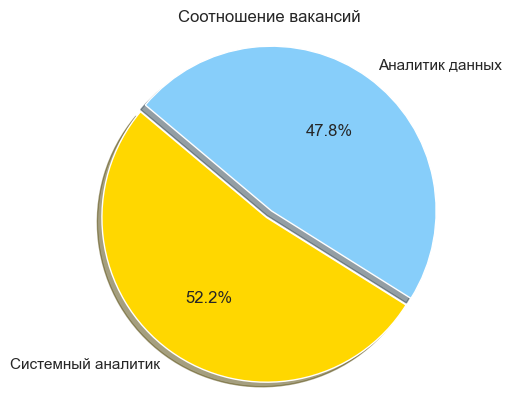

In [72]:


# Подсчет вакансий
total_vacancies = len(df)
sa_vacancies = df[df['source'] == 'vacancies_sa'].shape[0]
da_vacancies = df[df['source'] == 'vacancies_da'].shape[0]

display(f'Общее число вакансий: {total_vacancies}')
display(f'Вакансии системного аналитика: {sa_vacancies}')
display(f'Вакансии аналитика данных: {da_vacancies}')

# Построение круговой диаграммы
labels = ['Системный аналитик', 'Аналитик данных']
sizes = [sa_vacancies, da_vacancies]
colors = ['gold', 'lightskyblue']
explode = (0.05, 0)  # Выделение первого сектора

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Равные оси для круга
plt.title('Соотношение вакансий')
plt.show()

<span style="color: blue;"><span style="color: blue;">Видим, что вакансий для системного аналитика (1915 вакансий, 52,2%) больше нежели для аналитика данных(1754 вакансии, 47,8%)</span></span>

### Распределение грейдов по всему датасету

experience
junior+ (1-3 years)      52.33
middle (3-6 years)       39.96
junior (no experince)     6.19
senior (6+ years)         1.53
Name: proportion, dtype: float64

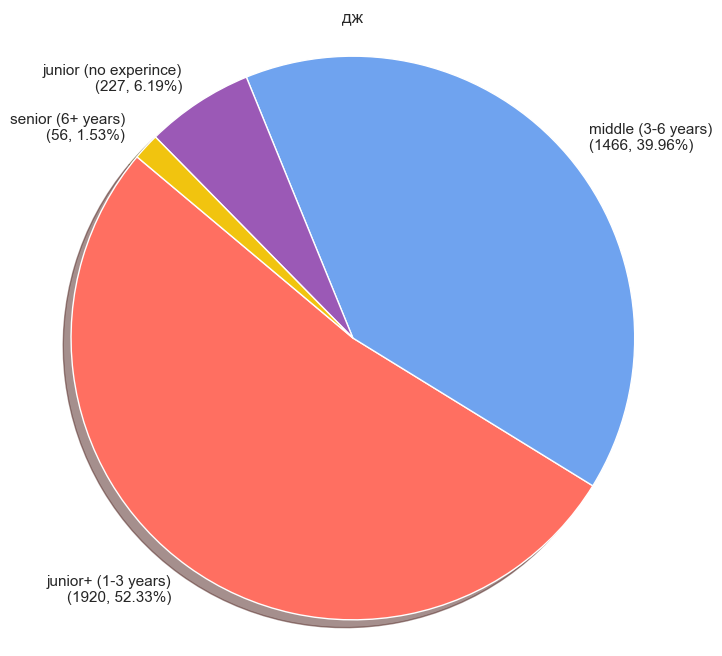

In [75]:
# Фильтрация DataFrame для вакансий системного аналитика и аналитика данных
sa_experience = df[df['source'] == 'vacancies_sa']['experience']
da_experience = df[df['source'] == 'vacancies_da']['experience']

# Объединение данных
combined_experience = pd.concat([sa_experience, da_experience])

# Подсчет доли каждого уровня опыта с округлением до сотых
experience_distribution = (combined_experience.value_counts(normalize=True) * 100).round(2)

# Подсчет количества в каждом уровне опыта
experience_counts = combined_experience.value_counts()

# Объединение количества и процентов
experience_labels = [f'{label}\n({count}, {percent}%)' for label, count, percent in zip(experience_distribution.index, experience_counts, experience_distribution)]

display(experience_distribution)

# Построение круговой диаграммы
sizes = experience_distribution.values

# Использование палитры с интересными цветами
colors = ['#FF6F61', '#6FA3EF', '#9B59B6', '#F1C40F', '#2ECC71']

# Создание круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=experience_labels, colors=colors, autopct=' ', startangle=140, shadow=True)  # Убираем автозначения
plt.axis('equal')  # Установить равные оси, чтобы круг выглядел правильно

plt.title('дж')
plt.show()

## Распределение вакансий по городам. Взяли топ-10 городов для обеих вакансий.

,vacancies_da,vacancies_sa
area,,
москва,1215.0,1134.0
санкт-петербург,174.0,223.0
екатеринбург,50.0,60.0
нижний новгород,33.0,33.0
новосибирск,32.0,49.0
владивосток,30.0,0.0
казань,26.0,51.0
краснодар,22.0,29.0
самара,11.0,29.0


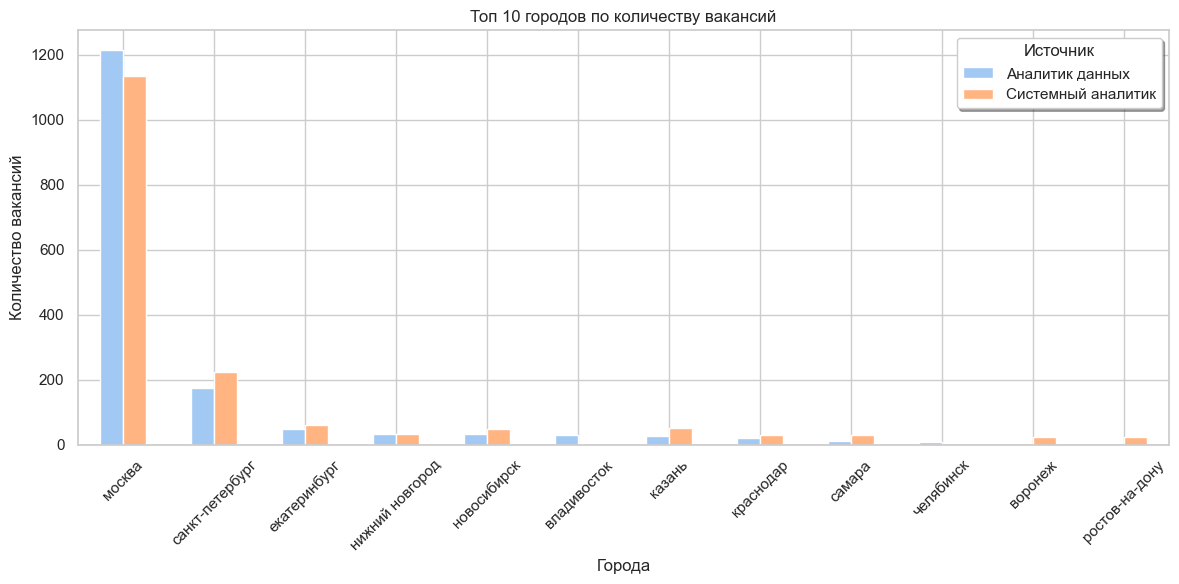

In [77]:
# Фильтруем DataFrame для вакансий "аналитик данных"
data_analyst_vacancies_da = df[df['source'] == 'vacancies_da']
top_cities_da = data_analyst_vacancies_da['area'].value_counts().head(10)

# Фильтруем DataFrame для вакансий "системный аналитик" 
data_analyst_vacancies_sa = df[df['source'] == 'vacancies_sa']
top_cities_sa = data_analyst_vacancies_sa['area'].value_counts().head(10)

# Объединяем данные для визуализации
top_cities = pd.DataFrame({
    'vacancies_da': top_cities_da,
    'vacancies_sa': top_cities_sa
}).fillna(0)  # Заполняем NaN значениями 0

# Сортируем данные по убыванию
top_cities_sorted = top_cities.sort_values(by='vacancies_da', ascending=False)

# Печатаем таблицу с полученными данными
display(top_cities_sorted)

# Строим график
top_cities_sorted.plot(kind='bar', figsize=(12, 6))
plt.title('Топ 10 городов по количеству вакансий')
plt.ylabel('Количество вакансий')
plt.xlabel('Города')
plt.xticks(rotation=45)
plt.legend(title='Источник', shadow=True, labels=['Аналитик данных', 'Системный аналитик'])
plt.tight_layout()
plt.show()

На основе представленных данных о количестве вакансий для должностей "аналитик данных" и "системный аналитик" по различным городам, можно сделать следующие выводы:

1. **Москва** является лидером по числу вакансий в обеих категориях:
   - Вакансий для аналитиков данных: 1215
   - Вакансий для системных аналитиков: 1134
   Это говорит о высоком уровне спроса на эти профессии в столице, что может быть связано с концентрацией компаний и бизнесов, нуждающихся в аналитике данных.

2. **Санкт-Петербург** занимает второе место, однако количество вакансий значительно ниже, чем в Москве:
   - 174 вакансии для аналитиков данных и 223 для системных аналитиков. Это также обозначает стабильный интерес к этим профессиям, хотя и на меньшем уровне по сравнению с Москвой.

3. В **Екатеринбурге** присутствует более низкий уровень вакансий (50 для аналитиков данных и 60 для системных аналитиков). Это может указывать на развивающийся рынок труда или наличие менее крупных компаний в этом регионе.

4. В городах **Нижний Новгород** и **Новосибирск** наблюдается почти одинаковое количество вакансий:
   - Нижний Новгород: 33 и 33 соответственно.
   - Новосибирск: 32 и 49 соответственно.
   Это может указывать на схожие условия труда и потребности компаний в этих регионах.

5. В **Владивостоке** количество вакансий для аналитиков данных (30) отсутствует для системных аналитиков, что может говорить о том, что данная специализация не так востребована в этом городе.

6. **Казань** и **Краснодар** демонстрируют смешанные результаты:
   - В Казани: 26 вакансий для аналитиков данных и 51 для системных аналитиков, что может указывать на большую потребность в системных аналитиках.
   - В Краснодаре: 22 и 29 соответственно, что также указывает на стабильный интерес.

7. В **Самаре** и **Челябинске** наблюдается низкое количество вакансий в обеих категориях, особенно в Челябинске, где 10 вакансий для аналитиков данных и отсутствие вакансий для системных аналитиков.

8. В **Воронеже** и **Ростове-на-Дону** также присутствуют вакансии только для системных аналитиков, при этом в Воронеже количество вакансий для аналитиков данных составляет 0, а в Ростове-на-Дону также отсутствуют вакансии для аналитиков данных (0). Это может означать недостаток спроса на эту профессию в данных регионах.

### Общий вывод:

В целом, количество вакансий для аналитиков данных и системных аналитиков сильно варьируется по регионам, с явным лидерством Москвы и Санкт-Петербурга. В других городах проявляется разнообразие интересов к различным специальностям, что может отражать экономические условия и потребности в соответствующие профессиональные навыки. Регионы с низким числом вакансий могут нуждаться в резком увеличении интереса к профессиям в области аналитики данных, чтобы удовлетворить растущий спрос на рынке труда.

<h2 style="color: blue;">Анализ количества вакансий по уровням опыта</h2>

<p style="color: blue;">
    Больше всего предложений для специалистов с опытом:
</p>
<ul style="color: blue;">
    <li><strong>Junior+ (1-3 года опыта)</strong>: 1920 вакансий</li>
    <li><strong>Middle (3-6 лет опыта работы)</strong></li>
</ul>
<p style="color: blue;">
    Меньше всего предложений для:
</p>
<ul style="color: blue;">
    <li><strong>Senior (6+ лет опыта)</strong>: 56 вакансий</li>
    <li><strong>Junior (без опыта)</strong></li>
</ul>

### Рассмотрим распределения вакансий по грейдам для аналитика данных и системного аналитика

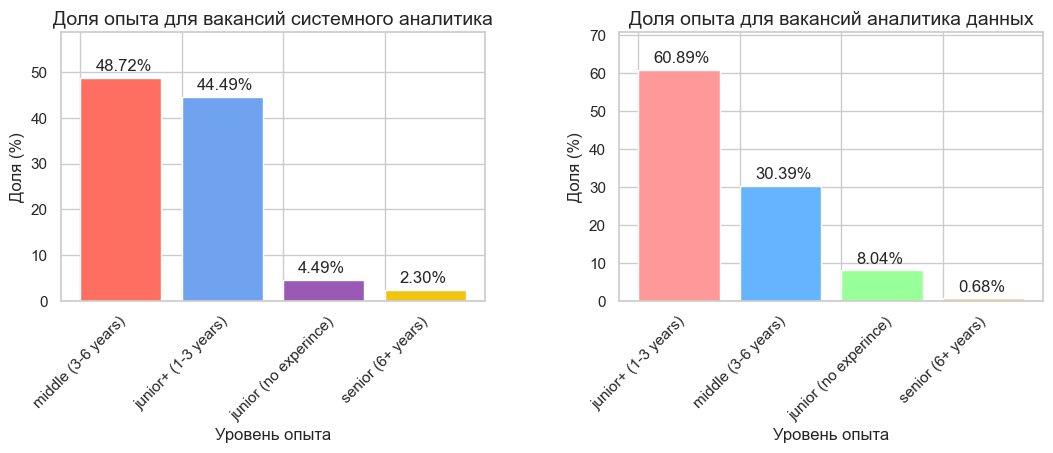

In [81]:
# Фильтрация DataFrame для вакансий системного аналитика
sa_experience = df[df['source'] == 'vacancies_sa']['experience']

# Подсчет доли каждого уровня опыта с округлением до сотых для системного аналитика
sa_experience_distribution = (sa_experience.value_counts(normalize=True) * 100).round(2)

# Фильтрация DataFrame для вакансий аналитика данных
da_experience = df[df['source'] == 'vacancies_da']['experience']

# Подсчет доли каждого уровня опыта с округлением до сотых для аналитика данных
da_experience_distribution = (da_experience.value_counts(normalize=True) * 100).round(2)

# Построение столбчатой диаграммы
labels_sa = sa_experience_distribution.index
sizes_sa = sa_experience_distribution.values

labels_da = da_experience_distribution.index
sizes_da = da_experience_distribution.values

# Создание подграфиков
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# График для системного аналитика
ax[0].bar(labels_sa, sizes_sa, color=['#FF6F61', '#6FA3EF', '#9B59B6', '#F1C40F', '#2ECC71'], align='edge')
ax[0].set_xlabel('Уровень опыта', fontsize=12)
ax[0].set_ylabel('Доля (%)', fontsize=12)
ax[0].set_title('Доля опыта для вакансий системного аналитика', fontsize=14)
ax[0].set_ylim(0, max(sizes_sa) + 10)  # Увеличение предела по оси Y для читаемости
ax[0].tick_params(axis='x', rotation=45)  # Поворот меток по оси X на 45 градусов для читаемости
for i, size in enumerate(sizes_sa):
    ax[0].text(i + 0.15, size + 1, f'{size:.2f}%', ha='left', va='bottom')  # Смещение текста вправо

# График для аналитика данных
ax[1].bar(labels_da, sizes_da, color=['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'], align='edge')
ax[1].set_xlabel('Уровень опыта', fontsize=12)
ax[1].set_ylabel('Доля (%)', fontsize=12)
ax[1].set_title('Доля опыта для вакансий аналитика данных', fontsize=14)
ax[1].set_ylim(0, max(sizes_da) + 10)  # Увеличение предела по оси Y для читаемости
ax[1].tick_params(axis='x', rotation=45)  # Поворот меток по оси X на 45 градусов для читаемости
for i, size in enumerate(sizes_da):
    ax[1].text(i + 0.15, size + 1, f'{size:.2f}%', ha='left', va='bottom')  # Смещение текста вправо

plt.tight_layout(pad=5.0)  # Увеличение отступов между подграфиками
plt.show()


<h2 style="color: blue;">Анализ востребованности специалистов</h2>

<p style="color: blue;">Для аналитиков данных наиболее востребованы специалисты:</p>
<ul style="color: blue;">
    <li><strong>Junior</strong> (1-3 лет опыта)</li>
</ul>

<p style="color: blue;">А для системных аналитиков наиболее востребованы специалисты:</p>
<ul style="color: blue;">
    <li><strong>Middle</strong> (3-6 лет опыта работы)</li>
</ul>

<p style="color: blue;">Для обоих вакансий наименее востребованы:</p>
<ul style="color: blue;">
    <li><strong>Senior</strong> (6+ лет опыта)</li>
</ul>


### Вызовем функцию для рассмотрения Топ-5 работодателей на вакансию аналитик данных для разных грейдов

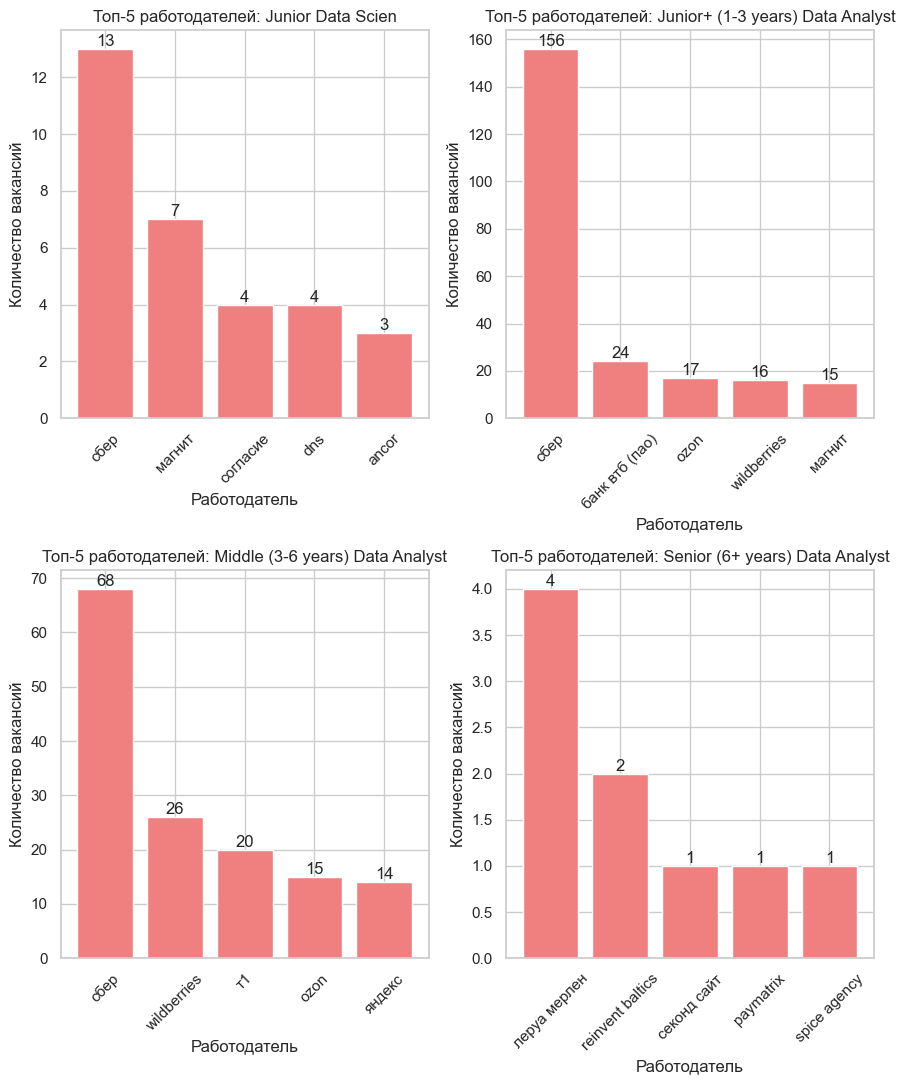

In [84]:
# Настройка графиков
fig, axs = plt.subplots(2, 2, figsize=(9, 11))  # 2 строки и 2 столбца

# Вызов функции для вывода графиков с указанными цветами
plot_top_employers(df, 'vacancies_da', 'junior (no experince)', 'Топ-5 работодателей: Junior Data Scien', axs[0, 0], color='lightcoral')
plot_top_employers(df, 'vacancies_da', 'junior+ (1-3 years)', 'Топ-5 работодателей: Junior+ (1-3 years) Data Analyst', axs[0, 1], color='lightcoral')
plot_top_employers(df, 'vacancies_da', 'middle (3-6 years)', 'Топ-5 работодателей: Middle (3-6 years) Data Analyst', axs[1, 0], color='lightcoral')
plot_top_employers(df, 'vacancies_da', 'senior (6+ years)', 'Топ-5 работодателей: Senior (6+ years) Data Analyst', axs[1, 1], color='lightcoral')

# Настройка общего внешнего вида
plt.tight_layout()  # Подгонка графиков
plt.show()  # Отображение графиков

<h2 style="color: blue;">Топ-5 работодателей на вакансию аналитик данных</h2>
<p style="color: blue;">Для большинства грейдов на вакансию аналитика данных лидером по количеству предложений оказался <strong>Сбер</strong>. Однако в топ-5 работодателей по количеству вакансий для senior грейда Сбер не вошел.</p>

<p style="color: blue;">Особенно Сбер выделился для грейдов:
</p>
<ul style="color: blue;">
    <li><strong>Junior+ (156 вакансий)</strong></li>
    <li><strong>Middle (68 вакансий)</strong></li>
</ul>
<p style="color: blue;">Сильно оставив ближайших преследователей позади:</p>
<ul style="color: blue;">
    <li>Банк <strong>ВТБ</strong> (24 вакансии для Middle)</li>
    <li><strong>Wildberries</strong> (26 вакансий для Junior +)</li>
</ul>
<p style="color: blue;">Лидером для грейда <strong>Senior</strong> оказался <strong>Леруа Мерлен</strong> с 4 вакансиями.</p>

<p style="color: blue;">Помимо Сбера, в двух грейдах по вакансиям оказался:</p>
<ul style="color: blue;">
    <li><strong>Магнит</strong>: 15 вакансий для Junior+ и 7 вакансий для Junior.</li>
    <li><strong>Ozon</strong>: 17 вакансий для Junior + и 15 вакансий для Middle.</li>
</ul>

### Вызовем функцию для рассмотрения Топ-5 работодателей на вакансию системный аналитик для разных грейдов

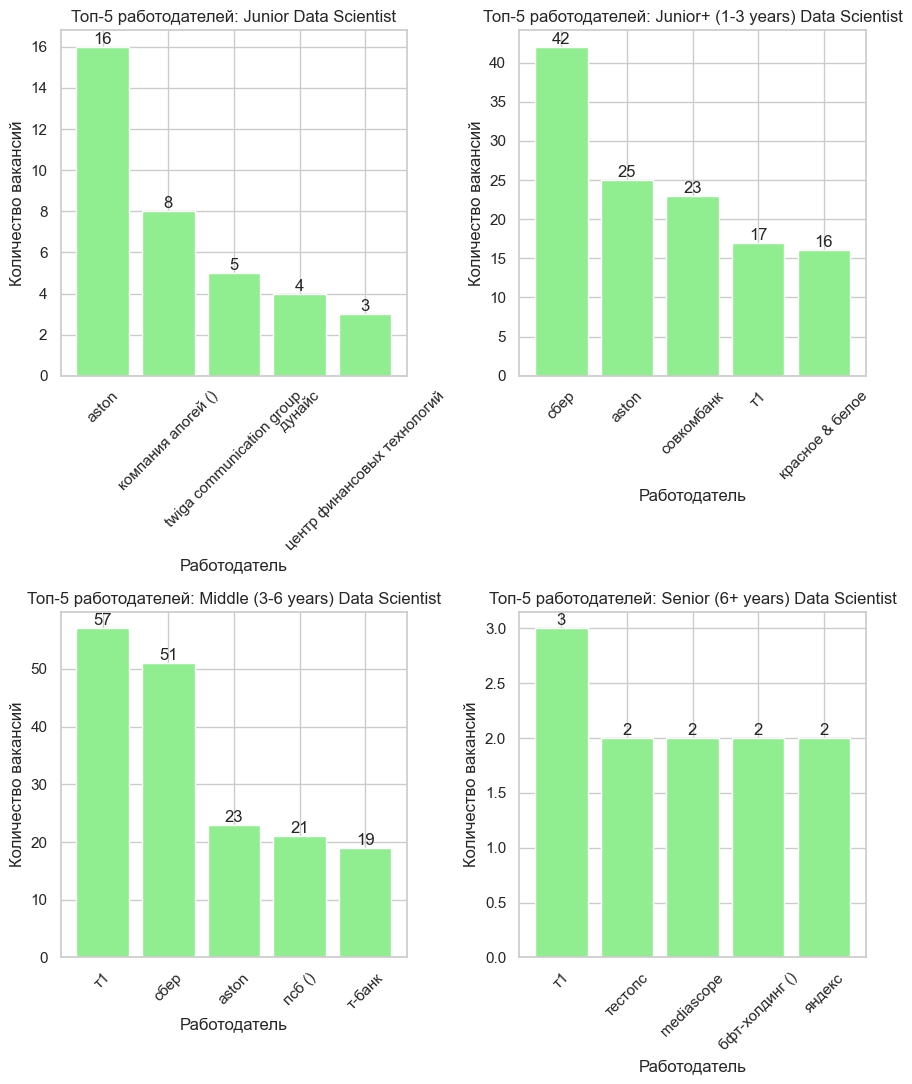

In [87]:
# Настройка графиков
fig, axs = plt.subplots(2, 2, figsize=(9, 11))  # 2 строки и 2 столбца

# Вызов функции для вывода графиков с указанными цветами
plot_top_employers(df, 'vacancies_sa', 'junior (no experince)', 'Топ-5 работодателей: Junior Data Scientist', axs[0, 0], color='lightgreen')
plot_top_employers(df, 'vacancies_sa', 'junior+ (1-3 years)', 'Топ-5 работодателей: Junior+ (1-3 years) Data Scientist', axs[0, 1], color='lightgreen')
plot_top_employers(df, 'vacancies_sa', 'middle (3-6 years)', 'Топ-5 работодателей: Middle (3-6 years) Data Scientist', axs[1, 0], color='lightgreen')
plot_top_employers(df, 'vacancies_sa', 'senior (6+ years)', 'Топ-5 работодателей: Senior (6+ years) Data Scientist', axs[1, 1], color='lightgreen')

# Настройка общего внешнего вида
plt.tight_layout()  # Подгонка графиков
plt.show()  # Отображение графиков

<h2 style="color: blue;">Топ-5 работодателей на вакансию системного аналитика</h2>
<p style="color: blue;">На вакансию системного аналитика самым ярким работодателем оказалась <strong>IT-компания Т1</strong>. У нее больше всего вакансий на грейд <strong>Senior</strong> - 3 вакансии, когда у остальных по 2. Также мы помним, что наибольшее количество вакансий для системного аналитика относится к грейду <strong>Middle</strong>, и здесь Т1 также оказалась лидером - 57 вакансий, однако <strong>Сбер</strong> не сильно отстает - у него 51 вакансия.</p>

<p style="color: blue;">Среди грейда <strong>Junior+</strong> лидирует <strong>Сбер</strong> - 42 вакансии, за ним <strong>Компания Aston</strong> - 25 вакансий, <strong>Совкомбанк</strong> - 23 и Т1 - 17 вакансий.</p>

<p style="color: blue;">Среди грейда <strong>Junior</strong> лидирует <strong>Компания Aston</strong> - 16 вакансий, за ней <strong>Компания Апогей</strong> - 8 вакансий.</p>

### Изучим среднюю стартовую зарплату при трудоустройстве

### Вызовем функцию для изучения средней зарплаты на вакансию Аналитик данных для разных грейдов

In [91]:
# Вызов функции
get_average_salary(df, 'vacancies_da', 'Аналитик данных', 'junior (no experince)')
get_average_salary(df, 'vacancies_da', 'Аналитик данных', 'junior+ (1-3 years)')
get_average_salary(df, 'vacancies_da', 'Аналитик данных', 'middle (3-6 years)')
get_average_salary(df, 'vacancies_da', 'Аналитик данных', 'senior (6+ years)')

"Средняя зарплата для вакансий 'Аналитик данных' (junior (no experince)):"

'От: 63376.83, До: 76991.24'

"Средняя зарплата для вакансий 'Аналитик данных' (junior+ (1-3 years)):"

'От: 92148.88, До: 120400.09'

"Средняя зарплата для вакансий 'Аналитик данных' (middle (3-6 years)):"

'От: 162655.95, До: 228337.68'

"Средняя зарплата для вакансий 'Аналитик данных' (senior (6+ years)):"

'От: 156666.67, До: 240000.00'

### Вызовем функцию для изучения средней зарплаты на вакансию системный аналитик для разных грейдов

In [93]:
get_average_salary(df, 'vacancies_sa', 'Системный аналитик', 'junior (no experince)')
get_average_salary(df, 'vacancies_sa', 'Системный аналитик', 'junior+ (1-3 years)')
get_average_salary(df, 'vacancies_sa', 'Системный аналитик', 'middle (3-6 years)')
get_average_salary(df, 'vacancies_sa', 'Системный аналитик', 'senior (6+ years)')

"Средняя зарплата для вакансий 'Системный аналитик' (junior (no experince)):"

'От: 66856.10, До: 98345.95'

"Средняя зарплата для вакансий 'Системный аналитик' (junior+ (1-3 years)):"

'От: 131183.93, До: 181131.98'

"Средняя зарплата для вакансий 'Системный аналитик' (middle (3-6 years)):"

'От: 207479.37, До: 281947.24'

"Средняя зарплата для вакансий 'Системный аналитик' (senior (6+ years)):"

'От: 206697.78, До: 362857.14'

<p style="color: blue;">Как и ожидалось, от грейда к грейду зарплата растет. По каждому грейду зарплата у системных аналитиков выше нежули у аналитиков данных.</p>
<ul style="color: blue;">

### Рассмотрим распределение занятости для вакансий аналитика данных по грейдам

/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/4087222067.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=employment_counts.index, y=employment_counts.values, palette="viridis", ax=ax)
/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/4087222067.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Поворот меток по оси x для лучшей читаемости
/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/4087222067.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=employment_counts.index, y=employment_coun

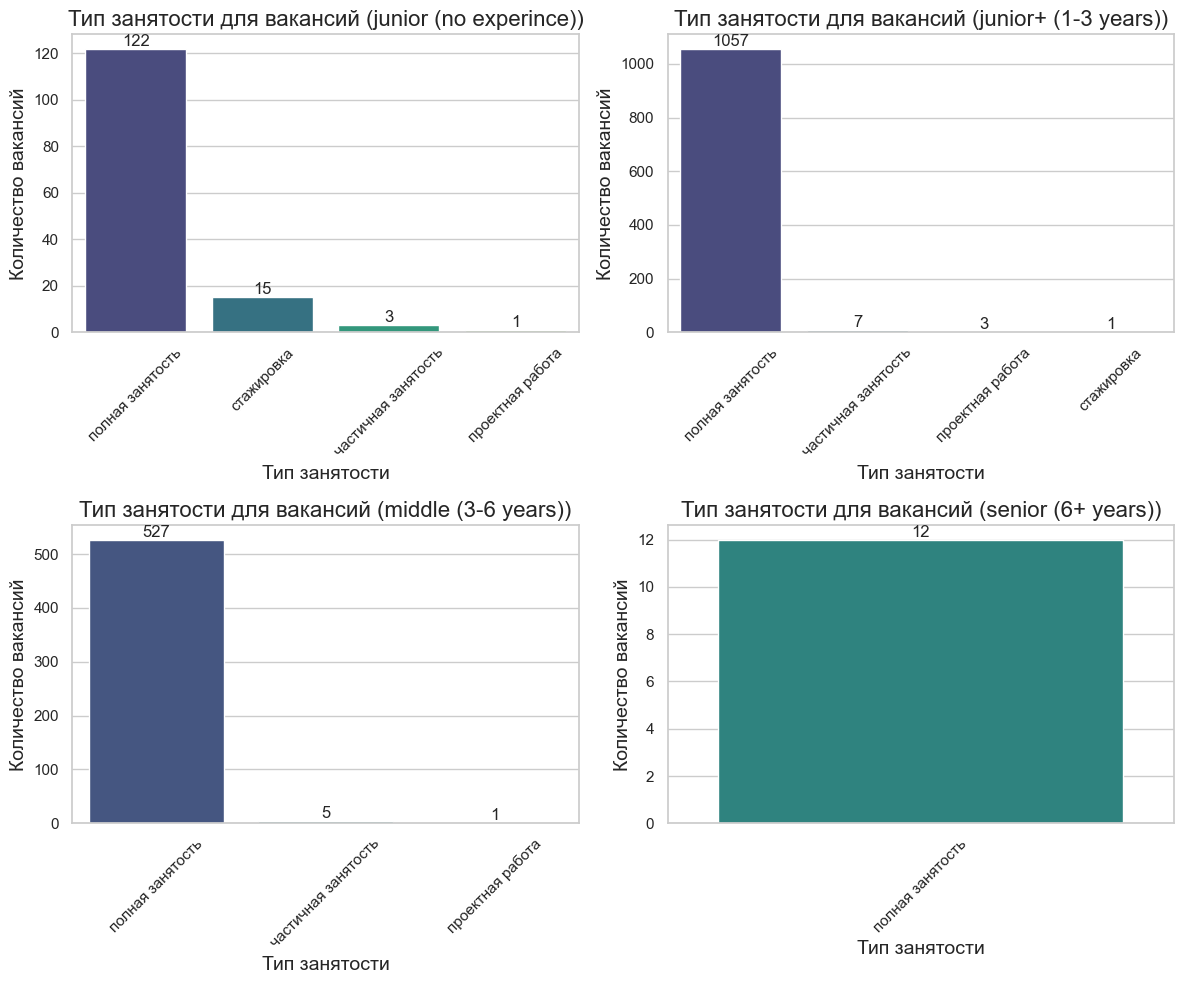

In [96]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_employment_distribution(df, 'vacancies_da', 'junior (no experince)', axs[0, 0])
plot_employment_distribution(df, 'vacancies_da', 'junior+ (1-3 years)', axs[0, 1])
plot_employment_distribution(df, 'vacancies_da', 'middle (3-6 years)', axs[1, 0])
plot_employment_distribution(df, 'vacancies_da', 'senior (6+ years)', axs[1, 1])

plt.show()

<h2 style="color: blue;">Анализ графиков занятости для вакансий аналитика данных</h2>
<p style="color: blue;">Проанализируем графики занятости для вакансий аналитика данных. Во всех грейдах наблюдается доминирование полной занятости:</p>

<ul style="color: blue;">
    <li><strong>Senior</strong>: 12 из 12 вакансий предлагают только полную занятость.</li>
    <li><strong>Middle</strong>: из 536 вакансий 1 – на проектную работу, 5 – на частичную занятость, остальные – на полную.</li>
    <li><strong>Junior+</strong>: из 1068 вакансий 1 – на стажировку, 3 – проектные, 7 – частичные, остальные – на полную занятость.</li>
    <li><strong>Junior (без опыта)</strong>: из 141 вакансии 1 – проектная, 3 – частичная занятость, 15 – стажировка, 122 – полная занятость.</li>
</ul>

### Рассмотрим распределение занятости для вакансий системного аналитика по грейдам

/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/4087222067.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=employment_counts.index, y=employment_counts.values, palette="viridis", ax=ax)
/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/4087222067.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Поворот меток по оси x для лучшей читаемости
/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/4087222067.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=employment_counts.index, y=employment_coun

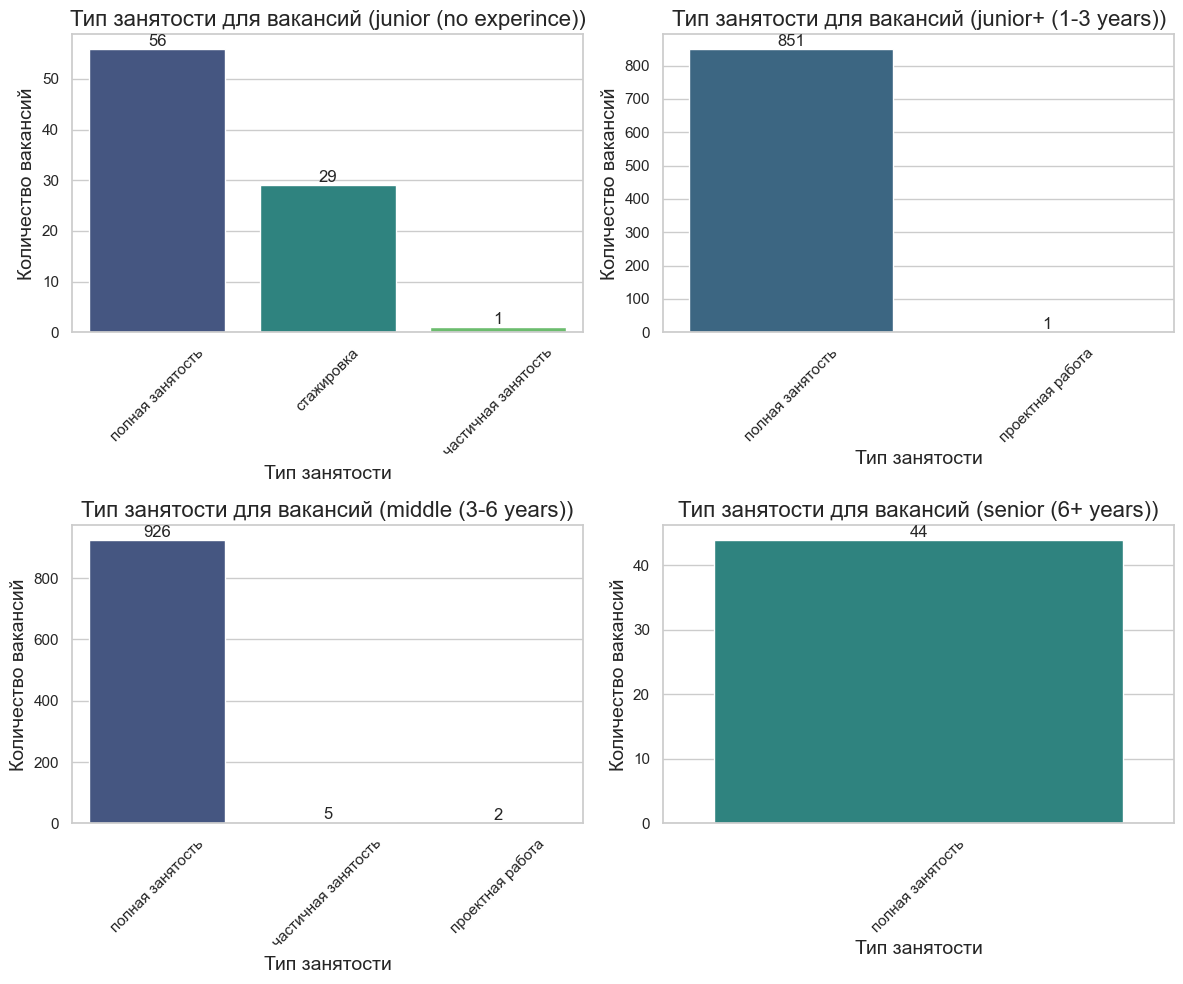

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_employment_distribution(df, 'vacancies_sa', 'junior (no experince)', axs[0, 0])
plot_employment_distribution(df, 'vacancies_sa', 'junior+ (1-3 years)', axs[0, 1])
plot_employment_distribution(df, 'vacancies_sa', 'middle (3-6 years)', axs[1, 0])
plot_employment_distribution(df, 'vacancies_sa', 'senior (6+ years)', axs[1, 1])

plt.show()

<h2 style="color: blue;">Анализ графиков занятости для вакансий системного аналитика</h2>
<p style="color: blue;">Проанализируем графики занятости для вакансий аналитика данных. Во всех грейдах наблюдается доминирование полной занятости:</p>

<ul style="color: blue;">
    <li><strong>Senior</strong>: 12 из 12 вакансий предлагают только полную занятость.</li>
    <li><strong>Middle</strong>: из 536 вакансий 1 – на проектную работу, 5 – на частичную занятость, остальные – на полную.</li>
    <li><strong>Junior+</strong>: из 1068 вакансий 1 – на стажировку, 3 – проектные, 7 – частичные, остальные – на полную занятость.</li>
    <li><strong>Junior (без опыта)</strong>: из 141 вакансии 1 – проектная, 3 – частичная занятость, 15 – стажировка, 122 – полная занятость.</li>
</ul>

### Рассмотрим распределение графика работы для вакансий аналитика данных по грейдам

/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/3299074161.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=schedule_counts.index, y=schedule_counts.values, palette="viridis", ax=ax)
/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/3299074161.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Поворот меток по оси x для лучшей читаемости
/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/3299074161.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=schedule_counts.index, y=schedule_counts.value

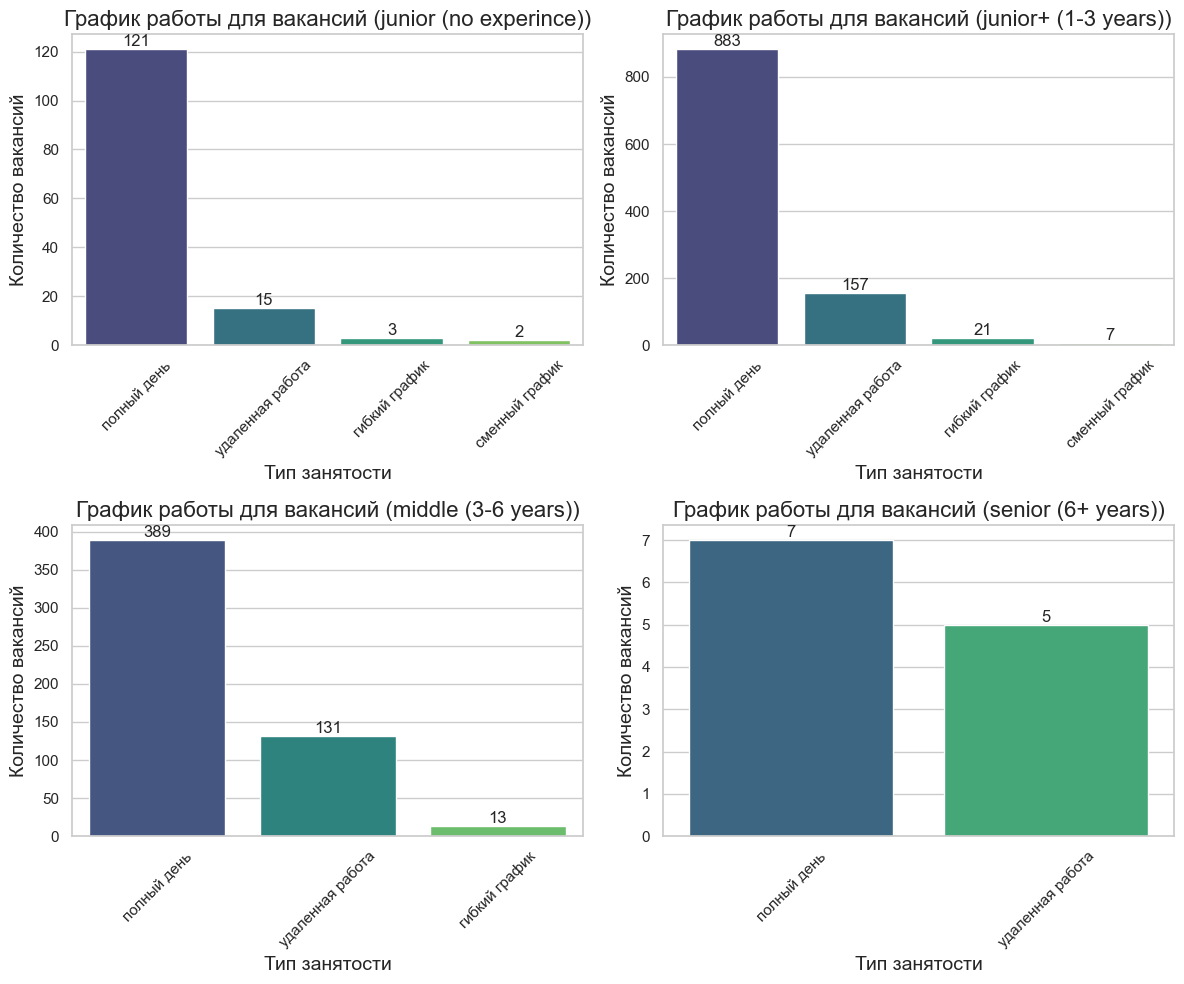

In [102]:
# Примеры вызова функции с осью
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plot_employment_distribution_1(df, 'vacancies_da', 'junior (no experince)', axs[0, 0])
plot_employment_distribution_1(df, 'vacancies_da', 'junior+ (1-3 years)', axs[0, 1])
plot_employment_distribution_1(df, 'vacancies_da', 'middle (3-6 years)', axs[1, 0])
plot_employment_distribution_1(df, 'vacancies_da', 'senior (6+ years)', axs[1, 1])

plt.show()

<h2 style="color: blue;">Анализ графиков работы для вакансий аналитика данных</h2>
<p style="color: blue;">Что касается графиков работы для аналитиков данных, то в большинстве случаев наблюдается преимущество полного рабочего дня. Не будем заострять на этом внимание, рассмотрим, что ещё предлагают работодатели по другим графикам.</p>

<ul style="color: blue;">
    <li><strong>Senior</strong>: из 12 вакансий 5 являются удалёнными.</li>
    <li><strong>Middle</strong>: из 533 вакансий 13 имеют гибкий график, а для 131 вакансии предоставляется возможность работы удалённо.</li>
    <li><strong>Junior +</strong>: из 1058 вакансий 7 имеют сменный график, 21 - гибкий график и 157 вакансий предлагают удалённую работу.</li>
    <li><strong>Junior (без опыта)</strong>: из 141 вакансии 2 со сменным графиком, 3 с гибким графиком и 15 - удалённые.</li>
</ul>
<p style="color: blue;">Таким образом, работодатели предлагают разнообразные форматы работы, включая удалённую и гибкую занятость.</p>

### Рассмотрим распределение графика работы для вакансий системного аналитика по грейдам

/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/3299074161.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=schedule_counts.index, y=schedule_counts.values, palette="viridis", ax=ax)
/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/3299074161.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Поворот меток по оси x для лучшей читаемости
/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_24504/3299074161.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=schedule_counts.index, y=schedule_counts.value

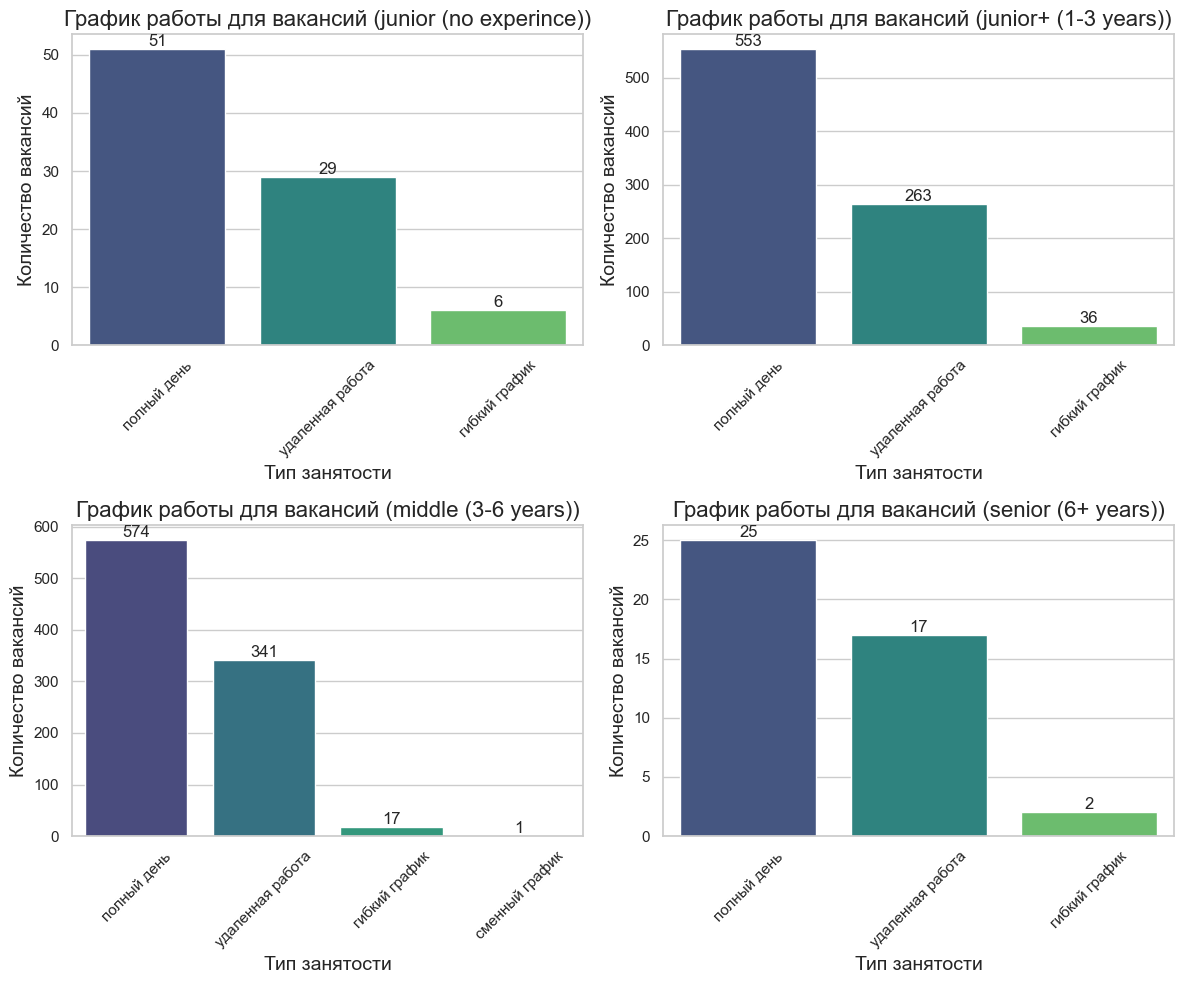

In [105]:
# Примеры вызова функции с осью
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plot_employment_distribution_1(df, 'vacancies_sa', 'junior (no experince)', axs[0, 0])
plot_employment_distribution_1(df, 'vacancies_sa', 'junior+ (1-3 years)', axs[0, 1])
plot_employment_distribution_1(df, 'vacancies_sa', 'middle (3-6 years)', axs[1, 0])
plot_employment_distribution_1(df, 'vacancies_sa', 'senior (6+ years)', axs[1, 1])

plt.show()

<h2 style="color: blue;">Анализ графиков работы для вакансий системного аналитика</h2>
<p style="color: blue;">Проанализируем график работы для вакансий системного аналитика. Как и для аналитика данных, вакансии преимущественно предлагают занятость на полный рабочий день. Рассмотрим детали по каждому грейду:</p>

<ul style="color: blue;">
    <li><strong>Senior</strong>: из 44 вакансий 2 имеют гибкий график, 17 предлагают возможность работать удалённо.</li>
    <li><strong>Middle</strong>: картина достаточно обширная. Из 933 вакансий 1 со сменным графиком, 17 с гибким, 341 вакансия предлагает возможность работать удалённо.</li>
    <li><strong>Junior +</strong>: ситуация схожа с грейдом middle, из 852 вакансий 36 имеют гибкий график, а 263 вакансии позволяют удалённую работу.</li>
    <li><strong>Junior (без опыта)</strong>: из 86 вакансий 6 имеют гибкий график, а 29 - удалённые.</li>
</ul>
<p style="color: blue;">Таким образом, можно наблюдать разнообразие графиков работы и возможность удалённой занятости для системных аналитиков.</p>

### Вывод по типичному месту работы для Аналитика данных и Системного аналитика.

### Общий вывод

Анализ вакансий для аналитиков данных и системных аналитиков демонстрирует несколько ключевых тенденций и тенденций на рынке труда:

1. **Лидеры по количеству вакансий**: 
   - Сбер выступает как основной работодатель по количеству вакансий для большинства грейдов, однако не попадает в топ-5 для senior-грейда. Для данной категории выделяются компании Т1 и Леруа Мерлен, которые предлагают больше вакансий для более опытных специалистов. Согласно региональной разбивке, Москва и Санкт-Петербург остаются основными центрами, где сосредоточены вакансии, что подтверждает важность этих городов как центров экономики и технологий.

2. **Ситуация по грейдам**: 
   - В грейде Junior+ лидирует Сбер с 42 вакансиями, за ним идет Компания Aston (25 вакансий) и Совкомбанк (23 вакансии). В Junior грейде доминирует Компания Aston с 16 вакансиями. В сегменте системных аналитиков Т1 представляет наибольшее количество вакансий для Senior и Middle грейдов. Это может свидетельствовать о том, что компании активно ищут талантливых специалистов, чтобы расширить свои команды и улучшить качество предоставляемых услуг.

3. **Рабочие графики**: 
   - В большинстве вакансий наблюдается преобладание полной занятости. Для Senior вакансий все 12 предложений предполагают полную занятость. Аналогично, в Middle из 536 вакансий только 6 предлагают частичную или проектную занятость. Среди Junior+ и Junior (без опыта) также преобладает полная занятость, но встречаются стажировки и проектные вакансии. Это подчеркивает растущий интерес к долгосрочным и стабильным трудовым отношениям со стороны работодателей.

4. **Удаленная и гибкая работа**: 
   - Несмотря на преобладание полной занятости, работы с гибкими и удаленными графиками также присутствуют. Например, в среде Senior вакансий 5 предлагают удаленную работу, а в Middle — 131. Для Junior+ и Junior (без опыта) также доступны варианты гибкого и удаленного графиков. Это может указывать на то, что работодатели понимают важность гибкости на современном рынке и стремятся удовлетворить потребности работников.

5. **Заработная плата**: 
   - Как и ожидалось, зарплата растет от Junior к Senior. При этом системные аналитики, в целом, получают более высокие компенсации по сравнению с аналитиками данных в каждом из грейдов. Также стоит отметить, что в зависимости от региона (например, Москва по сравнению с другими городами) наблюдаются значительные различия в уровне заработной платы, что подчеркивает важность выбора местоположения при поиске работы.

6. **Региональные различия**: 
   - В других городах, таких как Екатеринбург, Казань и Новосибирск, наблюдается гораздо меньшее количество вакансий, особенно для аналитиков данных, что может говорить о меньшей активности рынка труда в этих регионах. Это создает возможности для экспансии компаний и привлечения талантливых специалистов в регионы с низким уровнем вакансий.

### Заключение

Таким образом, рынок вакансий для аналитиков данных и системных аналитиков показывает высокую конкуренцию среди работодателей и разнообразие возможностей для соискателей. Растущие требования к квалификации и опытности подчеркивают важность повышения профессионального уровня специалистов, что, в свою очередь, способствует более высокой компенсации и созданию гибких условий работы. Региональные различия в наличии вакансий и уровне заработной платы указывают на необходимость соискателям учитывать не только сами вакансии, но и рынок труда в своем регионе при принятии решений о карьере.

### Определение наиболее часто встречающихся требований (hard_skills или soft_skills) на вакансии аналитика данных и системного аналитика.

In [110]:
# Применяем функцию с указанием столбца, который содержит навыки hard_skills
result_table = count_skills(df, 'hard_skills')

# Выводим результат
print('Таблица по вакансиям с Hard skills')
display(result_table)

Таблица по вакансиям с Hard skills


,Вакансия,Грейд,Общее количество вакансий,Вакансии со скилами,% вакансий со скилами
0,Аналитик данных,junior (no experince),141,70,49.65
1,Аналитик данных,junior+ (1-3 years),1068,594,55.62
2,Аналитик данных,middle (3-6 years),533,314,58.91
3,Аналитик данных,senior (6+ years),12,10,83.33
4,Системный аналитик,junior (no experince),86,45,52.33
5,Системный аналитик,junior+ (1-3 years),852,528,61.97
6,Системный аналитик,middle (3-6 years),933,594,63.67
7,Системный аналитик,senior (6+ years),44,32,72.73


<span style="color: blue;">
Вакансия Аналитик данных:
    
- Наибольшее количество Hard skills требуется для грейда junior+ (1-3 года) — 594. Однако в процентном соотношении количества вакансий со скилами относительно общего количества вакансий наибольший показатель у senior (6+ years)	- 83.33%.
     
- Наименьшее количество Hard skills требуется для грейда senior (6+ лет) — 10. Но в процентном соотношении наименьший показатель у грейда junior (no experince) - 49,65%

Вакансия Системный аналитик:
- Наибольшее количество требований зафиксировано для грейда middle (3-6 лет) — 594. А процентное соотношение количества вакансий со скилами относительно общего количества вакансий наибольший показатель у senior (6+ years) - 72,73%.
- Наименьшее количество Hard skills требуется для грейда senior (6+ лет) — 32. Но в процентном соотношении наименьший показатель у грейда junior (no experince) - 52,33%
</span>

In [112]:
# Применяем функцию с указанием столбца, который содержит навыки soft_skills
result_table = count_skills(df, 'soft_skills')

# Выводим результат
print('Таблица по вакансиям с Soft skills')
display(result_table)

Таблица по вакансиям с Soft skills


,Вакансия,Грейд,Общее количество вакансий,Вакансии со скилами,% вакансий со скилами
0,Аналитик данных,junior (no experince),141,18,12.77
1,Аналитик данных,junior+ (1-3 years),1068,129,12.08
2,Аналитик данных,middle (3-6 years),533,47,8.82
3,Аналитик данных,senior (6+ years),12,2,16.67
4,Системный аналитик,junior (no experince),86,23,26.74
5,Системный аналитик,junior+ (1-3 years),852,47,5.52
6,Системный аналитик,middle (3-6 years),933,35,3.75
7,Системный аналитик,senior (6+ years),44,3,6.82


<span style="color: blue;">
Вакансия Аналитик данных:
    
- Наибольшее количество Soft skills требуется для грейда junior+ (1-3 года) — 129. Однако в процентном соотношении количества вакансий со скилами относительно общего количества вакансий наибольший показатель у senior (6+ years)	- 16,67%.
     
- Наименьшее количество Soft skills требуется для грейда senior (6+ лет) — 2. Но в процентном соотношении наименьший показатель у грейда middle (3-6 years) - 8,82%

Вакансия Системный аналитик:
- Наибольшее количество требований зафиксировано для грейда junior+ (1-3 years) — 47. А процентное соотношение количества вакансий со скилами относительно общего количества вакансий наибольший показатель у junior (no experince) - 26,74%.
- Наименьшее количество Soft skills требуется для грейда senior (6+ лет) — 3. Но в процентном соотношении наименьший показатель у грейда middle (3-6 years) - 3,75%
</span>

### Общий вывод

Анализ вакансий для аналитиков данных и системных аналитиков по требованиям к Hard и Soft скиллам демонстрирует четкую динамику, указывающую на разные конкурентные важности этих навыков в зависимости от уровня грейда.

1. **Тенденция Hard скиллов**: Как для аналитиков данных, так и для системных аналитиков наблюдается явный рост процентного соотношения вакансий, требующих Hard скиллы, с увеличением уровня грейда. Это говорит о том, что с ростом опыта и квалификации от специалистов ожидается более высокая степень технической компетенции. В случаях с грейдом Senior (6+ лет) специалисты требуют проведения сложных задач и использования специализированных инструментов, что и отражает высокое процентное соотношение.

2. **Тенденция Soft скиллов**: Напротив, в области требований к Soft скиллам наблюдается снижение процентного соотношения вакансий, где они необходимы, по мере увеличения грейда. Эта динамика может говорить о том, что в начале карьеры Soft скиллы, такие как коммуникация и работа в команде, становятся более востребованными для успешной интеграции в коллектив, в то время как для более опытных специалистов акцент смещается на технические знания и способности.

3. **Выбросы в данных**: Особое внимание заслуживает ситуация с грейдом Senior (6+ лет) для аналитиков данных, где процентное соотношение Soft скиллов значительно выше по сравнению с другими грейдами. Тем не менее, учитывая небольшую выборку вакансий, это значение можно рассматривать как выброс, что свидетельствует о необходимости осторожного подхода при интерпретации таких данных.

4. **Выводы для карьерного роста**: Таким образом, специалисты в области аналитики должны учитывать необходимость акцента на Hard скиллах в процессе повышения квалификации, в то время как для начальных уровней развития важность Soft скиллов остается ключевой. Успешный карьерный путь требует балансирования между развитием этих двух категорий навыков, что будет способствовать как личному, так и профессиональному росту в условиях конкурентного рынка труда.

# Определение наиболее желаемых кандидатов по топ скиллам на вакансии аналитика данных и системного аналитика с разбивкой по грейдам

### Для начала необходимо выделить топ-5 hard и soft навыков отдельно для аналитиков данных и системных аналитиков. Такой подход будет более корректным, поскольку требуемые навыки для системного аналитика не всегда совпадают с навыками, необходимыми аналитикам данных. 

### Разделение навыков по этим двум ролям позволит точнее определить, какие качества и умения нужны в каждой из профессий, и поможет в дальнейшем при отборе сотрудников. Также при оценке я буду опираться на показатель '% соотношение вакансий со скилами относительно общего количества вакансий', думаю это более корректно так как в грейде senior (6+ years) в целом мало вакансий относительно других грейдов

### <span style="color: blue;">Найдем топ-5 Hard скиллов для вакансии аналитик данных.</span>

In [119]:
result_table = get_most_common_skills(df, 'hard_skills', source_value='vacancies_da', top_n=5)
display(result_table)

,Скилл,Количество
0,sql,747
1,python,556
2,power bi,222
3,ms excel,206
4,математическая статистика,95


### <span style="color: blue;">Найдем топ-5 Soft скиллов для вакансии аналитик данных.</span>

In [121]:
result_table = get_most_common_skills(df, 'soft_skills', source_value='vacancies_da', top_n=5)
display(result_table)

,Скилл,Количество
0,статистический анализ,68
1,английский язык,42
2,подготовка презентаций,32
3,математический анализ,30
4,работа в команде,27


### <span style="color: blue;">Найдем топ-5 Hard скиллов для вакансии системного аналитика.</span>

In [123]:
result_table = get_most_common_skills(df, 'hard_skills', source_value='vacancies_sa', top_n=5)
display(result_table)

,Скилл,Количество
0,sql,673
1,bpmn,635
2,системный анализ,564
3,uml,561
4,rest,391


### <span style="color: blue;">Найдем топ-5 Soft скиллов для вакансии системного аналитика.</span>

In [125]:
result_table = get_most_common_skills(df, 'soft_skills', source_value='vacancies_sa', top_n=5)
display(result_table)

,Скилл,Количество
0,английский язык,33
1,аналитический склад ума,27
2,работа в команде,26
3,деловая коммуникация,23
4,подготовка презентаций,8


### Распределение процентного соотношения вакансий с топовыми Hard скиллами для вакансии аналитик данных.

,experience,Count,Total Vacancies,Percentage
0,junior (no experince),64,141,45.39
1,junior+ (1-3 years),575,1068,53.84
2,middle (3-6 years),294,533,55.16
3,senior (6+ years),9,12,75.00


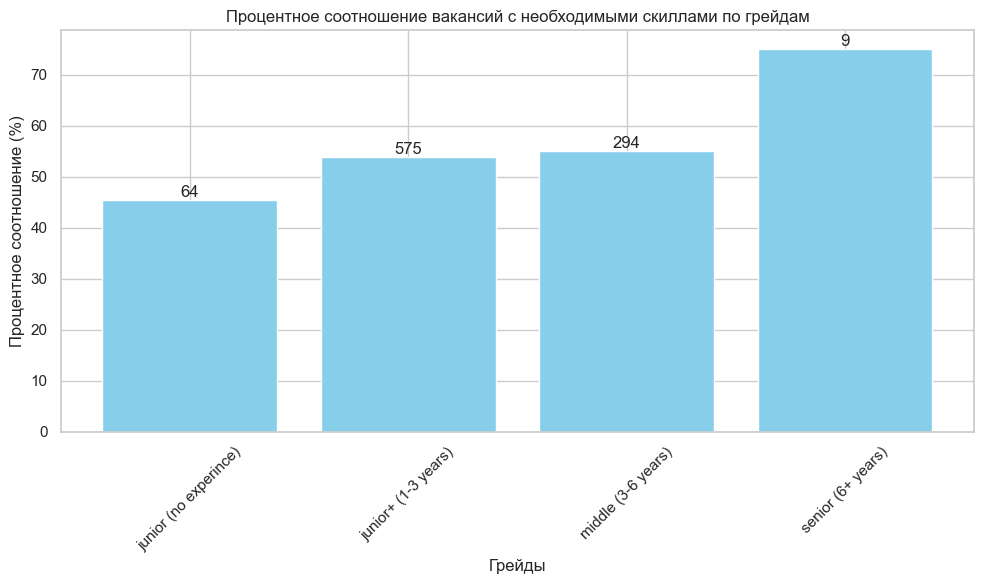

In [127]:
required_skills = {'sql', 'python', 'power bi', 'ms excel', 'математическая статистика'}
source_value = 'vacancies_da'  # Значение столбца df['source']
plot_skill_distribution(df, required_skills, source_value, 'hard_skills')

<span style="color: blue;">Как и ожидалось, что с ростом грейда растет показатель % вакансий, где требуются топовые Hard скилы.</span>

### Распределение процентного соотношения вакансий с топовыми Soft скиллами для вакансии аналитик данных.

,experience,Count,Total Vacancies,Percentage
0,junior (no experince),16,141,11.35
1,junior+ (1-3 years),106,1068,9.93
2,middle (3-6 years),45,533,8.44
3,senior (6+ years),2,12,16.67


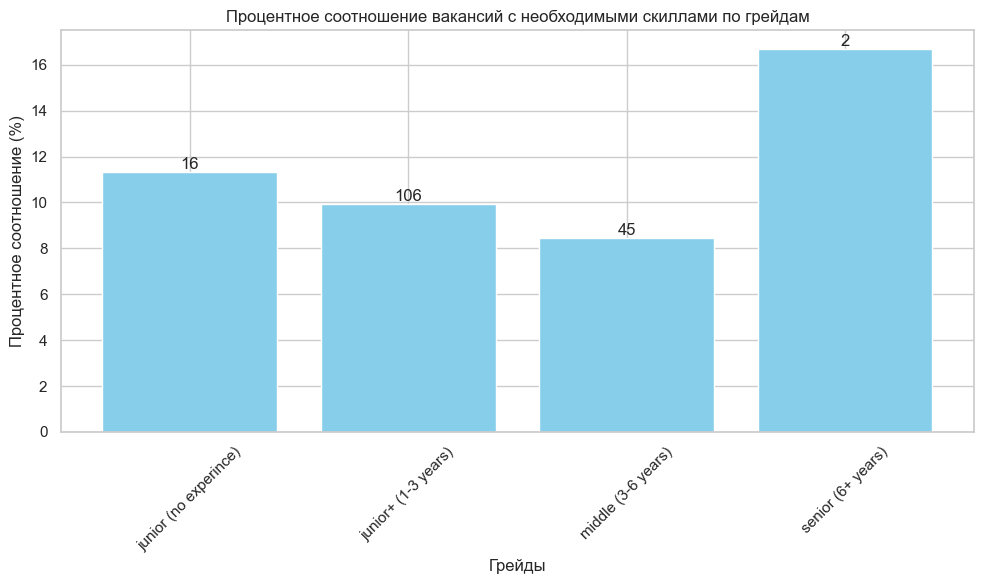

In [130]:
required_skills = {'статистический анализ', 'английский язык', 'подготовка презентаций', 'математический анализ', 'работа в команде'}
source_value = 'vacancies_da'  # Значение столбца df['source']
plot_skill_distribution(df, required_skills, source_value, 'soft_skills')

<span style="color:blue">Если не учитывать грейды Senior (6+), которые обычно имеют множество требований и крайне ограниченную выборку, можно сделать вывод, что с увеличением уровня грейда процент вакансий, требующих софт-скиллов, снижается.</span>

### Распределение процентного соотношения вакансий с топовыми Hard скиллами для вакансии системный аналитик.

,experience,Count,Total Vacancies,Percentage
0,junior (no experince),39,86,45.35
1,junior+ (1-3 years),475,852,55.75
2,middle (3-6 years),551,933,59.06
3,senior (6+ years),29,44,65.91


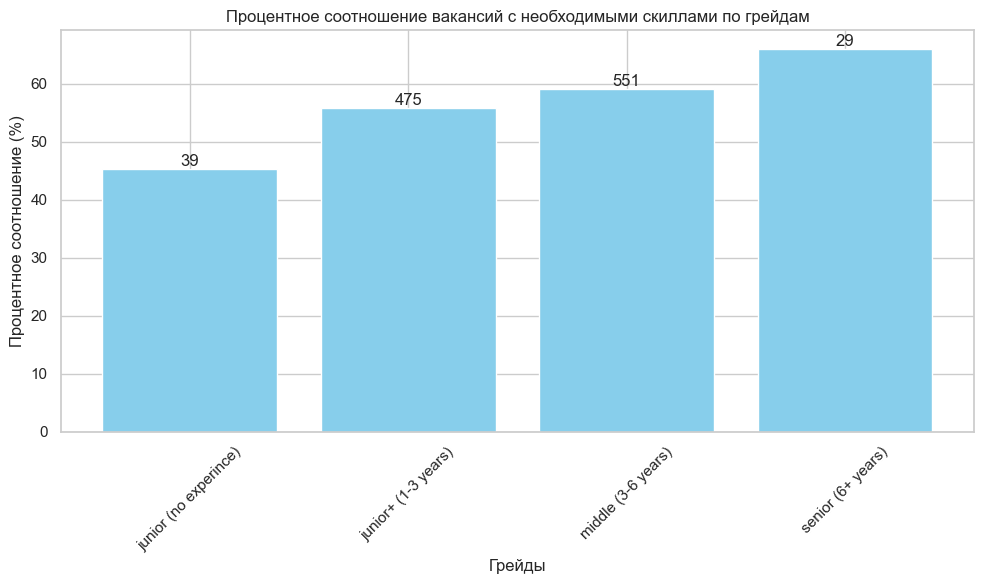

In [133]:
required_skills = {'sql', 'bpmn', 'системный анализ', 'uml', 'rest'}
source_value = 'vacancies_sa'  # Значение столбца df['source']
plot_skill_distribution(df, required_skills, source_value, 'hard_skills')

<span style="color: blue;">Ситуация для системного аналитика аналогична вакансии аналитика данных, где также наблюдается, что с ростом грейда увеличивается процент вакансий, требующих высоких Hard скилов.</span>

### Распределение процентного соотношения вакансий с топовыми Soft скиллами для вакансии системный аналитик.

,experience,Count,Total Vacancies,Percentage
0,junior (no experince),22,86,25.58
1,junior+ (1-3 years),47,852,5.52
2,middle (3-6 years),35,933,3.75
3,senior (6+ years),3,44,6.82


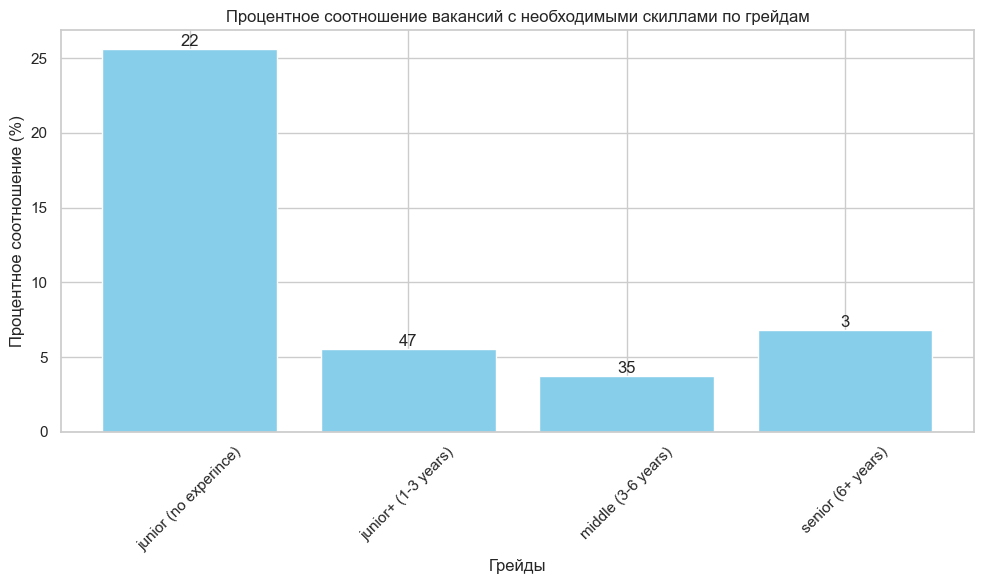

In [136]:
required_skills = {'аналитический склад ума', 'английский язык', 'работа в команде', 'деловая коммуникация', 'подготовка презентаций'}
source_value = 'vacancies_sa'  # Значение столбца df['source']
plot_skill_distribution(df, required_skills, source_value, 'soft_skills')

<span style="color: blue;">Распределение вакансий системного аналитика по софт-скилам аналогично распределению для вакансий аналитика данных. Однако график для системного аналитика менее плавный, поскольку процент вакансий для начинающих специалистов (junior, без опыта) почти в 5 раз выше, чем у сотрудников с другими грейдами.</span>

### Общий вывод

Анализ распределения вакансий для аналитиков данных и системных аналитиков по требованиям к Hard и Soft скиллам показывает четкую тенденцию, подтверждающую важность специализации и уровня опыта в профессии.

1. **Рост требований к Hard скиллам**: Как и ожидалось, с увеличением уровня грейда возрастает процент вакансий, где востребованы высокие Hard скиллы, такие как программирование, работа с данными и специализированные инструменты анализа. Это связано с растущими ожиданиями работодателей относительно технической компетенции сотрудников, что подчеркивает необходимость постоянного обучения и саморазвития специалистам, стремящимся к карьере в области аналитики.

2. **Снижение значения Soft скиллов**: В то же время с ростом грейда наблюдается снижение процентного соотношения вакансий, требующих развитых Soft скиллов. Для начинающих специалистов Soft скиллы, такие как коммуникация и работа в команде, становятся более значимыми, поскольку они способствуют успешной интеграции в коллектив и обеспечивают эффективное обучение. Это указывает на необходимость акцентирования внимания на этих навыках в первые годы карьеры.

3. **Сравнение по специальностям**: Аналогичная динамика наблюдается в вакансиях для системных аналитиков, где процент требований к Hard скиллам также растет с увеличением уровня грейда. При этом графики распределения Soft скиллов показывают большую вариативность для системных аналитиков, особенно для начальных уровней, что указывает на специфические требования в данной роли.

4. **Заключение о карьерных путях**: Таким образом, карьерный путь в области аналитики данных и системного анализа требует от специалистов баланса между развитием Hard скиллов и Soft скиллов. Начинающим специалистам следует сосредоточиться на освоении Soft скиллов, в то время как более опытные профессионалы должны уделять больше внимания технической подготовке и углублению знаний в своей сфере. Это понимание критически важно для успешного карьерного роста и соответствия ожиданиям работодателей в быстроменяющемся мире рынка труда.

### Вывод о проделанной исследовательской работе

Исследование по вакансиям для аналитиков данных и системных аналитиков выявило ключевые тенденции на рынке труда, которые имеют важное значение как для работодателей, так и для соискателей.

1. **Анализ спроса и предложений**: Исследование показало, что компании, такие как Сбер и Т1, занимают лидирующие позиции по количеству вакансий, что указывает на актуальность и востребованность специалистов в данной области. Это также подчеркивает значимость крупных городов, таких как Москва и Санкт-Петербург, как центров трудовой активности.

2. **Грейды и требования**: Обозначение требований по грейдам позволяет глубже понять, какие навыки являются наиболее ценными на разных уровнях квалификации. В частности, результаты показали рост требований к Hard скиллам с увеличением опыта, что свидетельствует о высоких ожиданиях работодателей от более опытных специалистов. В то же время специалисты начального уровня должны концентрироваться на развитии Soft скиллов, которые являются важными для успешной интеграции в команду. 

   - **Тенденция Hard скиллов**: Как и ожидалось, с увеличением уровня грейда возрастает процент вакансий, где востребованы высокие Hard скиллы, такие как программирование, работа с данными и специализированные инструменты анализа. Это связано с растущими ожиданиями работодателей относительно технической компетенции сотрудников, что подчеркивает необходимость постоянного обучения и саморазвития специалистам, стремящимся к карьере в области аналитики.

   - **Тенденция Soft скиллов**: В то же время с ростом грейда наблюдается снижение процентного соотношения вакансий, требующих развитых Soft скиллов. Для начинающих специалистов Soft скиллы, такие как коммуникация и работа в команде, становятся более значимыми, поскольку они способствуют успешной интеграции в коллектив и обеспечивают эффективное обучение. Это указывает на необходимость акцентирования внимания на этих навыках в первые годы карьеры.

3. **Рабочие условия и гибкость**: Наблюдение за преобладанием вакансий с полной занятостью, а также растущим интересом к гибким и удалённым условиям, демонстрирует адаптацию компаний к изменяющимся потребностям работников. Это может повысить общий уровень удовлетворенности сотрудников и помочь в привлечении талантливых специалистов.

4. **Региональная динамика**: Исследование также обнаружило значительные региональные различия в количестве вакансий и уровне заработной платы, что подчеркивает необходимость для соискателей учитывать местные рыночные условия при выборе места работы. Этот фактор может влиять как на стратегии поиска работы, так и на карьерные амбиции специалистов.


### Заключение

Таким образом, исследовательская работа предоставляет ценную информацию о текущем состоянии рынка труда для аналитиков данных и системных аналитиков. Она подчеркивает важность постоянного профессионального развития, баланса между Hard и Soft скиллами, а также учета региональных и экономических факторов для успешной карьеры. Результаты могут быть использованы как для формирования стратегий обучения и развития, так и для создания более эффективных методов подбора кадров для работодателей. 

Специалистам следует уделять внимание развитию как технических, так и межличностных навыков в зависимости от уровня их опыта. Этот баланс будет способствовать успешной карьере и соответствию ожиданиям работодателей на сегодня и в будущем.